In [1]:
import glob
import numpy as np
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
import mdshare
import pyemma
from tqdm.notebook import tqdm
from matplotlib import rc
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
#from scipy.stats import gaussian_kde

import seaborn as sns


In [2]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.serif": ["computer modern roman"],
    "font.size": 12})
plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

nn=np.linspace(-1,3)

# Load Data

In [3]:
data = []
lendata = []

#Loop through the directories containing the paths
for directory in glob.glob("./run*",recursive=True):
    print("Directory",directory)
    #Loop through the paths
    pathname=directory+"/CVscreeningeneptm.dat"
    print(directory,pathname)
    for file in glob.glob(pathname):      
        inp = np.loadtxt(file, skiprows=2,usecols=np.arange(0,18))
        data.append(inp)
        lendata.append(len(inp))

# Data concatenated
Data = np.concatenate(data)
Data = np.delete(Data,0,1)
numCVs = Data.shape[1]
datalabels = ["cn.mean","ncl","ncs","Q4.mean","q4.mean","ncnq4","laQ4.mean","Q6.mean","q6.mean","ncnq6","laQ6.mean","ent","nclust1", "ene", "non", "fcc", "hcp"]
#datalabels = ["cn.mean","ncl","ncs","Q4.mean","q4.mean","ncnq4","laq4.mean","Q6.mean","q6.mean","ncnq6","laq6.mean","ent","nclust1", "ene", "non", "fcc", "hcp", "bcc", "ico"]


Directory ./run17
./run17 ./run17/CVscreeningeneptm.dat
Directory ./run178
./run178 ./run178/CVscreeningeneptm.dat
Directory ./run38
./run38 ./run38/CVscreeningeneptm.dat
Directory ./run39
./run39 ./run39/CVscreeningeneptm.dat
Directory ./run99
./run99 ./run99/CVscreeningeneptm.dat
Directory ./run612
./run612 ./run612/CVscreeningeneptm.dat
Directory ./run725
./run725 ./run725/CVscreeningeneptm.dat
Directory ./run525
./run525 ./run525/CVscreeningeneptm.dat
Directory ./run733
./run733 ./run733/CVscreeningeneptm.dat
Directory ./run287
./run287 ./run287/CVscreeningeneptm.dat


### Plot the time series

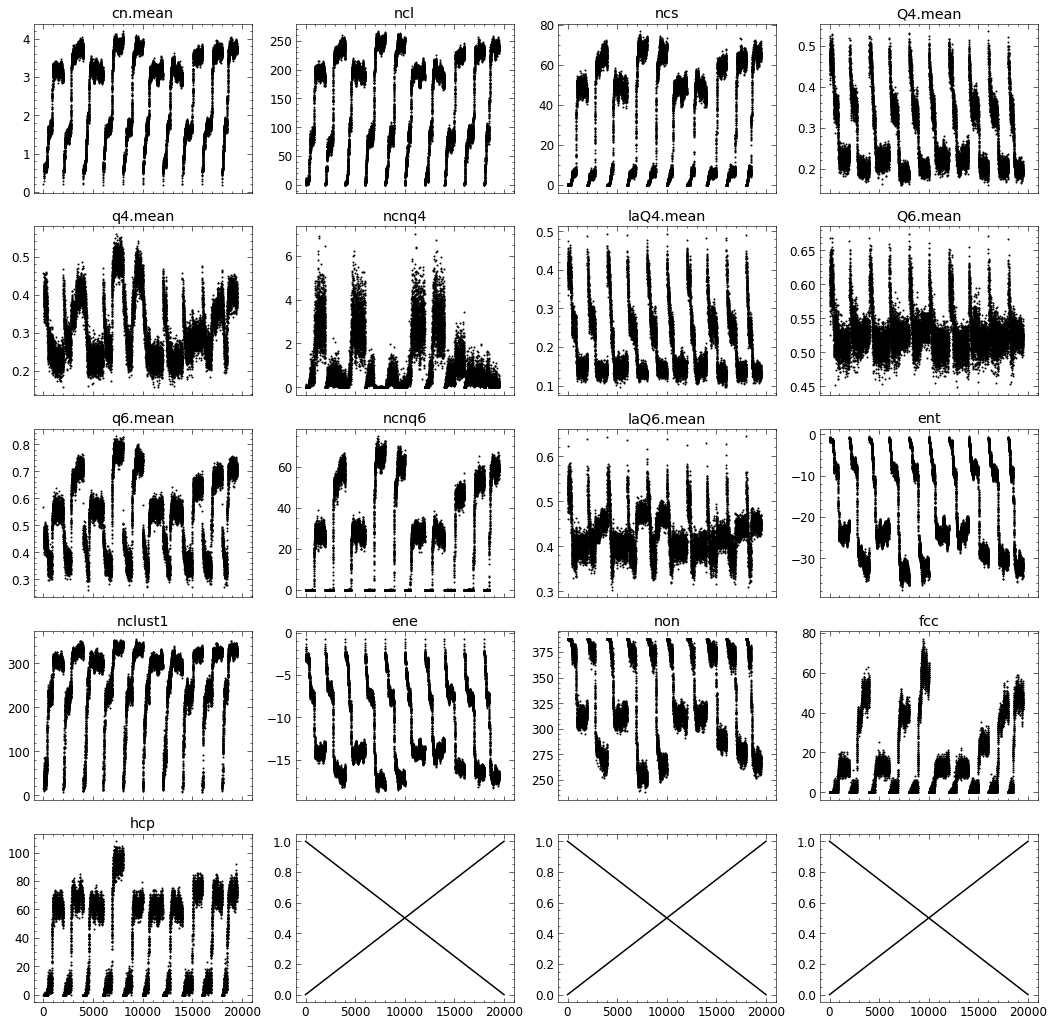

In [4]:
panels = int(np.sqrt(numCVs))+1
figure, axis = plt.subplots(panels, panels-1, figsize=(18,18), sharex=True)

cols = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18','C19','C20','C1']
c = 0
for i in range(0,panels):
    for j in range(0,panels-1):
        if c < numCVs:
            axis[i, j].plot(Data[0:-1:100,c],'ko',markersize=1)
            axis[i, j].set_title(format(datalabels[c]))
        else:
            axis[i, j].plot([0,20000],[1,0],'k-')
            axis[i, j].plot([0,20000],[0,1],'k-')
        c += 1

plt.show()
#plt.savefig('./CVsTimeseries.png', dpi=300, bbox_inches='tight')

### Plot Feature Histogram

In [5]:
DataNorm = np.zeros(Data.shape)
for i in range(0,numCVs):
    print(datalabels[i],np.amin(Data[:,i]),np.amax(Data[:,i]))
    DataNorm[:,i] = np.abs(Data[:,i])/np.amax(np.abs(Data[:,i]))


cn.mean 0.150477 4.209561
ncl 0.0022 267.382347
ncs 3.4e-05 76.965064
Q4.mean 0.153038 0.562416
q4.mean 0.143395 0.576264
ncnq4 0.0 9.238967
laQ4.mean 0.092013 0.502384
Q6.mean 0.404036 0.70567
q6.mean 0.253202 0.849934
ncnq6 1.3e-05 75.38844
laQ6.mean 0.288413 0.644195
ent -37.697048 -0.39205
nclust1 5.0 357.0
ene -18.919509 -0.71365639
non 234.0 388.0
fcc 0.0 78.0
hcp 0.0 111.0


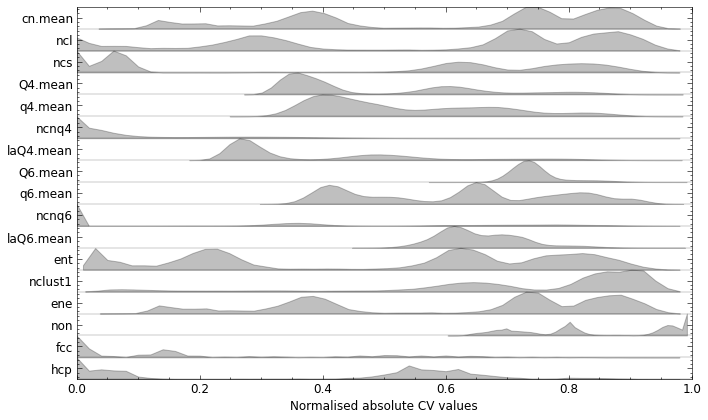

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
pyemma.plots.plot_feature_histograms(DataNorm,feature_labels=datalabels,ax=ax,color='black');
ax.set_xlim(0,1)
ax.set_xlabel('Normalised absolute CV values')
fig.tight_layout()
#plt.savefig('./CVdistnorm.png', dpi=300, bbox_inches='tight')

# Use VAMP to identify the best combinations of CVs

In [7]:
# Function to get the CV combinations without permutations

from deeptime.decomposition import vamp_score_cv
from itertools import chain, repeat, count, islice
from collections import Counter


def repeat_chain(values, counts):
    return chain.from_iterable(map(repeat, values, counts))


def unique_combinations_from_value_counts(values, counts, r):
    n = len(counts)
    indices = list(islice(repeat_chain(count(), counts), r))
    if len(indices) < r:
        return
    while True:
        yield tuple(values[i] for i in indices)
        for i, j in zip(reversed(range(r)), repeat_chain(reversed(range(n)), reversed(counts))):
            if indices[i] != j:
                break
        else:
            return
        j = indices[i] + 1
        for i, j in zip(range(i, r), repeat_chain(count(j), counts[j:])):
            indices[i] = j


def unique_combinations(iterable, r):
    values, counts = zip(*Counter(iterable).items())
    return unique_combinations_from_value_counts(values, counts, r)

In [8]:
from deeptime.decomposition import VAMP


# All possible CVs
numredCVfirst = 0
numredCVlast  = 6

cvs = list(range(0, numCVs)) # all CV indexes listed in order

myfile = open('VAMP_CVs1-6.txt', 'w') ####


lagt = 200
# Loop over the possible combination of i+1 CVs
for i in range(numredCVfirst,numredCVlast):
#for i in range(0,4):
    ncombgrp = [] # list of number of groups
    combgrp = [] # list of groups
    combscore = [] # list of scores
    comberr = [] # list of errors
    
    
    # Get the combinations
    combs = list(unique_combinations(cvs, i+1))
    #combs = list(unique_combinations([0, 1, 2, 3], i+1))
    ncombs = len(combs)
    print("Number of CVs in the group",i+1,"Number of groups",ncombs) 
    myfile.write("{} {} {} {} \n".format("Number of CVs in the group",i+1,"Number of groups",ncombs)) 
    ncombgrp.append(ncombs)
    
    # Loop through the combinations
    for j in range(0,ncombs):
        ####print("j",j,combs[j],len(combs[j]))
        combgrp.append(combs[j])
        cdim = len(combs[j])
        
        # Get the new trajectory data
        DataComb = DataNorm[:,combs[j]]
         
        # Do VAMP2
        vamp_estimator = VAMP(dim=None, lagtime=lagt).fit(DataComb)
        dtraj = vamp_estimator.transform(DataComb)

        scores = vamp_score_cv(vamp_estimator, dim = None, trajs=dtraj, blocksplit=True, blocksize=5000)
        combscore.append(scores.mean())
        comberr.append(scores.std())
        
        myfile.write("{} {} {} {} \n".format(j,combs[j],combscore[j],comberr[j])) 
        print(j,combs[j],combscore[j])
        myfile.flush() 
        
myfile.close()  

Number of CVs in the group 1 Number of groups 17
0 (0,) 1.9871050215975454
1 (1,) 1.9896998487686743
2 (2,) 1.9908973216183496
3 (3,) 1.9508581878206825
4 (4,) 1.8916618656421154
5 (5,) 1.741601960188585
6 (6,) 1.944896289429158
7 (7,) 1.563622025191028
8 (8,) 1.9636862297571134
9 (9,) 1.9883359989311138
10 (10,) 1.7870322973324915
11 (11,) 1.9901668761456335
12 (12,) 1.9735498643639986
13 (13,) 1.9892596299091063
14 (14,) 1.982491661562662
15 (15,) 1.978021221676579
16 (16,) 1.977318600492597
Number of CVs in the group 2 Number of groups 136
0 (0, 1) 2.0766097088287196
1 (0, 2) 2.8719399232649514
2 (0, 3) 2.3032007631061973
3 (0, 4) 2.8716795103804356
4 (0, 5) 2.7092533270892063
5 (0, 6) 2.570035029133697
6 (0, 7) 2.3977568486407783
7 (0, 8) 2.8583066318469172
8 (0, 9) 2.929447421617028
9 (0, 10) 2.765168883821171
10 (0, 11) 2.72740842259041
11 (0, 12) 2.8774756133726447
12 (0, 13) 2.044570794413088
13 (0, 14) 2.773959235814318
14 (0, 15) 2.928183472020217
15 (0, 16) 2.739323905742485

111 (0, 12, 14) 3.4265793001779477
112 (0, 12, 15) 3.7906033652835567
113 (0, 12, 16) 3.454413660243861
114 (0, 13, 14) 2.781430403014261
115 (0, 13, 15) 2.94260057513766
116 (0, 13, 16) 2.8089080517292433
117 (0, 14, 15) 3.5422635765430464
118 (0, 14, 16) 3.607065549319418
119 (0, 15, 16) 3.6661403256744194
120 (1, 2, 3) 3.044058047698011
121 (1, 2, 4) 3.728586362532725
122 (1, 2, 5) 3.6102734685938516
123 (1, 2, 6) 3.1476232320200404
124 (1, 2, 7) 3.048661571202251
125 (1, 2, 8) 3.378937879657845
126 (1, 2, 9) 3.8452002175141105
127 (1, 2, 10) 3.255938454253895
128 (1, 2, 11) 3.645284609339307
129 (1, 2, 12) 3.154925280496639
130 (1, 2, 13) 3.1787666121555285
131 (1, 2, 14) 3.5186772049258273
132 (1, 2, 15) 3.8299261333469703
133 (1, 2, 16) 3.4920068829874316
134 (1, 3, 4) 3.0384156167210024
135 (1, 3, 5) 2.9383607014074484
136 (1, 3, 6) 2.891832451370796
137 (1, 3, 7) 2.4649076824195326
138 (1, 3, 8) 2.945534461587349
139 (1, 3, 9) 3.022773004000763
140 (1, 3, 10) 2.9524653217968826

357 (3, 7, 16) 2.9902210819458914
358 (3, 8, 9) 3.379641003980886
359 (3, 8, 10) 2.7816715929327267
360 (3, 8, 11) 3.093671462638545
361 (3, 8, 12) 3.1033953853084433
362 (3, 8, 13) 2.9788077577157077
363 (3, 8, 14) 2.8932026668205246
364 (3, 8, 15) 3.5835341286279077
365 (3, 8, 16) 3.316788381518917
366 (3, 9, 10) 3.4033055654773157
367 (3, 9, 11) 3.1533378298914707
368 (3, 9, 12) 3.256067348397491
369 (3, 9, 13) 3.036129484466489
370 (3, 9, 14) 2.943263768170998
371 (3, 9, 15) 3.5938003393388342
372 (3, 9, 16) 3.4919548728069882
373 (3, 10, 11) 3.077303096503972
374 (3, 10, 12) 3.1070195778280336
375 (3, 10, 13) 2.968189944588731
376 (3, 10, 14) 2.9414147972110043
377 (3, 10, 15) 3.6093065991111266
378 (3, 10, 16) 3.3053334591149364
379 (3, 11, 12) 3.1070742202793142
380 (3, 11, 13) 2.9523508520341877
381 (3, 11, 14) 2.9725861661280115
382 (3, 11, 15) 3.3245940022920886
383 (3, 11, 16) 3.2827963245436416
384 (3, 12, 13) 3.0404961752239243
385 (3, 12, 14) 3.1417650019749495
386 (3, 12

599 (8, 9, 13) 3.410518733055779
600 (8, 9, 14) 3.0714035617648756
601 (8, 9, 15) 3.323880463818834
602 (8, 9, 16) 3.3697293033144584
603 (8, 10, 11) 3.0804512825626933
604 (8, 10, 12) 3.0948727700896286
605 (8, 10, 13) 2.9636748922194505
606 (8, 10, 14) 2.8867415786717343
607 (8, 10, 15) 3.5949893598447233
608 (8, 10, 16) 3.3342485868074974
609 (8, 11, 12) 3.2974333610533195
610 (8, 11, 13) 3.3483871077313188
611 (8, 11, 14) 2.9934334346296416
612 (8, 11, 15) 3.654178232866601
613 (8, 11, 16) 3.513614839438514
614 (8, 12, 13) 3.3041089692139645
615 (8, 12, 14) 2.9694122951826687
616 (8, 12, 15) 3.722195523571608
617 (8, 12, 16) 3.5548415489793284
618 (8, 13, 14) 3.003976701342792
619 (8, 13, 15) 3.6831407722460687
620 (8, 13, 16) 3.528967092969977
621 (8, 14, 15) 3.4935590756941175
622 (8, 14, 16) 3.4737945059000355
623 (8, 15, 16) 3.476401727042428
624 (9, 10, 11) 3.3132161460484952
625 (9, 10, 12) 3.009204784225299
626 (9, 10, 13) 3.2422590431885183
627 (9, 10, 14) 3.036207174262274

150 (0, 2, 6, 16) 3.6742140892433226
151 (0, 2, 7, 8) 3.491466537065675
152 (0, 2, 7, 9) 3.909244111373473
153 (0, 2, 7, 10) 3.6124000276181674
154 (0, 2, 7, 11) 3.665465062141022
155 (0, 2, 7, 12) 3.2084319598917697
156 (0, 2, 7, 13) 3.185341742608531
157 (0, 2, 7, 14) 3.5876088611280963
158 (0, 2, 7, 15) 3.886946795431134
159 (0, 2, 7, 16) 3.606472723213848
160 (0, 2, 8, 9) 3.91017684331005
161 (0, 2, 8, 10) 3.418434507000034
162 (0, 2, 8, 11) 3.8349554664155945
163 (0, 2, 8, 12) 3.5544376153432125
164 (0, 2, 8, 13) 3.483537961764133
165 (0, 2, 8, 14) 3.5983731682811646
166 (0, 2, 8, 15) 3.972439672586783
167 (0, 2, 8, 16) 3.8950706475464267
168 (0, 2, 9, 10) 3.8980061030080932
169 (0, 2, 9, 11) 4.214521212657404
170 (0, 2, 9, 12) 4.010677842925604
171 (0, 2, 9, 13) 3.8567779481072746
172 (0, 2, 9, 14) 3.890063755481107
173 (0, 2, 9, 15) 4.476092857787376
174 (0, 2, 9, 16) 4.371182832192589
175 (0, 2, 10, 11) 3.7347270671607085
176 (0, 2, 10, 12) 3.400742818515023
177 (0, 2, 10, 13) 

374 (0, 5, 10, 11) 3.633385936032763
375 (0, 5, 10, 12) 3.726300861414308
376 (0, 5, 10, 13) 3.4187432758147667
377 (0, 5, 10, 14) 3.5144447708268403
378 (0, 5, 10, 15) 3.87607267348466
379 (0, 5, 10, 16) 3.9049396588627254
380 (0, 5, 11, 12) 3.829760198296124
381 (0, 5, 11, 13) 3.5004519860631413
382 (0, 5, 11, 14) 3.628563845850543
383 (0, 5, 11, 15) 3.8780241232580996
384 (0, 5, 11, 16) 3.94440229063064
385 (0, 5, 12, 13) 3.6097738166573676
386 (0, 5, 12, 14) 3.72690496657861
387 (0, 5, 12, 15) 4.069631171175765
388 (0, 5, 12, 16) 4.091821485584329
389 (0, 5, 13, 14) 3.298244170015848
390 (0, 5, 13, 15) 3.287495804092747
391 (0, 5, 13, 16) 3.470879618516167
392 (0, 5, 14, 15) 3.869086743798481
393 (0, 5, 14, 16) 3.891755597578046
394 (0, 5, 15, 16) 4.0203385530331675
395 (0, 6, 7, 8) 3.0286937091400494
396 (0, 6, 7, 9) 3.1550369560376588
397 (0, 6, 7, 10) 3.0509663103414364
398 (0, 6, 7, 11) 3.050516295406323
399 (0, 6, 7, 12) 3.2779671273134285
400 (0, 6, 7, 13) 2.778747115245583
4

595 (1, 2, 5, 16) 4.1708155526072215
596 (1, 2, 6, 7) 3.30755892819069
597 (1, 2, 6, 8) 3.458717163839527
598 (1, 2, 6, 9) 3.9191553539166746
599 (1, 2, 6, 10) 3.3258194817622146
600 (1, 2, 6, 11) 3.8019526840955775
601 (1, 2, 6, 12) 3.379751678115793
602 (1, 2, 6, 13) 3.4388035435731616
603 (1, 2, 6, 14) 3.5924023389076636
604 (1, 2, 6, 15) 3.9153582156351883
605 (1, 2, 6, 16) 3.7268453728477837
606 (1, 2, 7, 8) 3.554948584055024
607 (1, 2, 7, 9) 3.9258827902716043
608 (1, 2, 7, 10) 3.650952155413299
609 (1, 2, 7, 11) 3.7302255879063715
610 (1, 2, 7, 12) 3.3037113614290115
611 (1, 2, 7, 13) 3.3083710351452424
612 (1, 2, 7, 14) 3.606256744042669
613 (1, 2, 7, 15) 3.9019827570942254
614 (1, 2, 7, 16) 3.632656382303194
615 (1, 2, 8, 9) 3.954840204258011
616 (1, 2, 8, 10) 3.482621248909625
617 (1, 2, 8, 11) 3.99990514394712
618 (1, 2, 8, 12) 3.6398579679960883
619 (1, 2, 8, 13) 3.651804132270152
620 (1, 2, 8, 14) 3.621986021050416
621 (1, 2, 8, 15) 4.055816334050847
622 (1, 2, 8, 16) 3.94

819 (1, 5, 8, 14) 3.5615274567687685
820 (1, 5, 8, 15) 4.01144756325621
821 (1, 5, 8, 16) 3.9743831837280474
822 (1, 5, 9, 10) 3.58525081683469
823 (1, 5, 9, 11) 3.9500275836319245
824 (1, 5, 9, 12) 3.8595886115461098
825 (1, 5, 9, 13) 3.6450757015374813
826 (1, 5, 9, 14) 3.510976617895466
827 (1, 5, 9, 15) 4.057768419689848
828 (1, 5, 9, 16) 3.9484690791681865
829 (1, 5, 10, 11) 3.8459123749519804
830 (1, 5, 10, 12) 3.7236740407242315
831 (1, 5, 10, 13) 3.617357585554494
832 (1, 5, 10, 14) 3.5139664637006254
833 (1, 5, 10, 15) 3.8846410570517187
834 (1, 5, 10, 16) 3.9247646849967692
835 (1, 5, 11, 12) 4.025126776788086
836 (1, 5, 11, 13) 3.7068832254559743
837 (1, 5, 11, 14) 3.8133706485008703
838 (1, 5, 11, 15) 4.020157032848874
839 (1, 5, 11, 16) 4.077416222475892
840 (1, 5, 12, 13) 3.8336705856647413
841 (1, 5, 12, 14) 3.724499729112422
842 (1, 5, 12, 15) 4.073935252838256
843 (1, 5, 12, 16) 4.091214328980399
844 (1, 5, 13, 14) 3.5251851019328866
845 (1, 5, 13, 15) 3.50836976497831

1039 (2, 3, 6, 8) 3.2780991814920086
1040 (2, 3, 6, 9) 3.8572844778137707
1041 (2, 3, 6, 10) 3.2250317546915204
1042 (2, 3, 6, 11) 3.781710377284346
1043 (2, 3, 6, 12) 3.5233443785335985
1044 (2, 3, 6, 13) 3.5971554411568234
1045 (2, 3, 6, 14) 3.5401158470912377
1046 (2, 3, 6, 15) 3.8857517007629276
1047 (2, 3, 6, 16) 3.6250299946479734
1048 (2, 3, 7, 8) 3.2557617327297104
1049 (2, 3, 7, 9) 3.6945977970519124
1050 (2, 3, 7, 10) 3.2506870954710814
1051 (2, 3, 7, 11) 3.3994052520243705
1052 (2, 3, 7, 12) 3.0792553159402654
1053 (2, 3, 7, 13) 3.1184872051069634
1054 (2, 3, 7, 14) 3.4017710126918543
1055 (2, 3, 7, 15) 3.6966754441054794
1056 (2, 3, 7, 16) 3.405686053051535
1057 (2, 3, 8, 9) 3.721568744368157
1058 (2, 3, 8, 10) 3.1753337930194943
1059 (2, 3, 8, 11) 3.7453108616483055
1060 (2, 3, 8, 12) 3.5263980901971257
1061 (2, 3, 8, 13) 3.5563617521320103
1062 (2, 3, 8, 14) 3.4138532379155704
1063 (2, 3, 8, 15) 3.849853917885814
1064 (2, 3, 8, 16) 3.7156911008801954
1065 (2, 3, 9, 10) 3.

1256 (2, 6, 14, 15) 3.998977570811828
1257 (2, 6, 14, 16) 4.017883986651611
1258 (2, 6, 15, 16) 4.022388804922368
1259 (2, 7, 8, 9) 3.6467386413756664
1260 (2, 7, 8, 10) 3.353284732669149
1261 (2, 7, 8, 11) 3.71945436128068
1262 (2, 7, 8, 12) 3.589684009807822
1263 (2, 7, 8, 13) 3.595900588175539
1264 (2, 7, 8, 14) 3.3887087933901396
1265 (2, 7, 8, 15) 3.763751605548343
1266 (2, 7, 8, 16) 3.518664868067412
1267 (2, 7, 9, 10) 3.9297807526726394
1268 (2, 7, 9, 11) 3.969585431361929
1269 (2, 7, 9, 12) 3.9365598159869277
1270 (2, 7, 9, 13) 3.9547187373725308
1271 (2, 7, 9, 14) 3.475522669751656
1272 (2, 7, 9, 15) 4.009099431167431
1273 (2, 7, 9, 16) 3.8651281702077056
1274 (2, 7, 10, 11) 3.8249472098769317
1275 (2, 7, 10, 12) 3.714821599649781
1276 (2, 7, 10, 13) 3.7368640414976335
1277 (2, 7, 10, 14) 3.5672254738030786
1278 (2, 7, 10, 15) 3.9163631469126208
1279 (2, 7, 10, 16) 3.593071787591761
1280 (2, 7, 11, 12) 3.746474970190448
1281 (2, 7, 11, 13) 3.75783892968843
1282 (2, 7, 11, 14) 

1472 (3, 5, 9, 10) 3.574160382039743
1473 (3, 5, 9, 11) 3.573382057218663
1474 (3, 5, 9, 12) 3.693300290401253
1475 (3, 5, 9, 13) 3.5274990033422684
1476 (3, 5, 9, 14) 3.384622281739271
1477 (3, 5, 9, 15) 3.9740665558259125
1478 (3, 5, 9, 16) 3.7461414691224943
1479 (3, 5, 10, 11) 3.699335091079925
1480 (3, 5, 10, 12) 3.6855752644086706
1481 (3, 5, 10, 13) 3.6086094186991913
1482 (3, 5, 10, 14) 3.4561708930979322
1483 (3, 5, 10, 15) 3.9242967498841552
1484 (3, 5, 10, 16) 3.7900059782848685
1485 (3, 5, 11, 12) 3.7260884540627117
1486 (3, 5, 11, 13) 3.580975944667948
1487 (3, 5, 11, 14) 3.4782262413634397
1488 (3, 5, 11, 15) 3.6600540447736534
1489 (3, 5, 11, 16) 3.778359929223993
1490 (3, 5, 12, 13) 3.6850807095143536
1491 (3, 5, 12, 14) 3.669064638468658
1492 (3, 5, 12, 15) 3.726777712586437
1493 (3, 5, 12, 16) 3.6869571191907027
1494 (3, 5, 13, 14) 3.423512736163599
1495 (3, 5, 13, 15) 3.4622224732338913
1496 (3, 5, 13, 16) 3.6644532397808036
1497 (3, 5, 14, 15) 3.8297281272529027
149

1686 (4, 5, 8, 11) 3.7756485498172765
1687 (4, 5, 8, 12) 3.930289225909277
1688 (4, 5, 8, 13) 3.828027056050689
1689 (4, 5, 8, 14) 3.581361393776465
1690 (4, 5, 8, 15) 3.787389764539634
1691 (4, 5, 8, 16) 3.510930277378784
1692 (4, 5, 9, 10) 3.7865521305099143
1693 (4, 5, 9, 11) 3.636289395504015
1694 (4, 5, 9, 12) 3.903935020953977
1695 (4, 5, 9, 13) 3.7067487102547956
1696 (4, 5, 9, 14) 3.3916627502971566
1697 (4, 5, 9, 15) 3.8830789975397044
1698 (4, 5, 9, 16) 3.671602832001973
1699 (4, 5, 10, 11) 3.769902865721474
1700 (4, 5, 10, 12) 3.678581699046812
1701 (4, 5, 10, 13) 3.763009543457346
1702 (4, 5, 10, 14) 3.7473458388448697
1703 (4, 5, 10, 15) 3.82979985056176
1704 (4, 5, 10, 16) 3.7416621147236393
1705 (4, 5, 11, 12) 3.950751428603938
1706 (4, 5, 11, 13) 3.864355979002415
1707 (4, 5, 11, 14) 3.4426196207545585
1708 (4, 5, 11, 15) 3.8607001763355555
1709 (4, 5, 11, 16) 3.8706478924941914
1710 (4, 5, 12, 13) 3.92928146820689
1711 (4, 5, 12, 14) 3.852418216235254
1712 (4, 5, 12, 1

1901 (5, 6, 8, 16) 3.8052846282696144
1902 (5, 6, 9, 10) 3.521705725411217
1903 (5, 6, 9, 11) 3.5934767463838613
1904 (5, 6, 9, 12) 3.6818907513465837
1905 (5, 6, 9, 13) 3.5215912461551113
1906 (5, 6, 9, 14) 3.4725058094744448
1907 (5, 6, 9, 15) 4.053072522675546
1908 (5, 6, 9, 16) 3.8231119003722585
1909 (5, 6, 10, 11) 3.6130628806316993
1910 (5, 6, 10, 12) 3.687019279202963
1911 (5, 6, 10, 13) 3.509881037828199
1912 (5, 6, 10, 14) 3.4388422246909798
1913 (5, 6, 10, 15) 3.901961249018413
1914 (5, 6, 10, 16) 3.7996292217545253
1915 (5, 6, 11, 12) 3.701635236844934
1916 (5, 6, 11, 13) 3.6538827780117935
1917 (5, 6, 11, 14) 3.557428323511387
1918 (5, 6, 11, 15) 3.829923670503361
1919 (5, 6, 11, 16) 3.8953514335736563
1920 (5, 6, 12, 13) 3.6819447800046623
1921 (5, 6, 12, 14) 3.6655905425318487
1922 (5, 6, 12, 15) 3.6275721732786286
1923 (5, 6, 12, 16) 3.6685727192945423
1924 (5, 6, 13, 14) 3.440145074516632
1925 (5, 6, 13, 15) 3.682671784484081
1926 (5, 6, 13, 16) 3.7685461666869733
1927

2115 (6, 9, 10, 12) 3.6639852132583806
2116 (6, 9, 10, 13) 3.4213645931873655
2117 (6, 9, 10, 14) 3.3580453939829775
2118 (6, 9, 10, 15) 3.965390996524931
2119 (6, 9, 10, 16) 3.774571624315373
2120 (6, 9, 11, 12) 3.8684495153859695
2121 (6, 9, 11, 13) 3.6814516994848603
2122 (6, 9, 11, 14) 3.347955454907865
2123 (6, 9, 11, 15) 3.954333479108352
2124 (6, 9, 11, 16) 3.9524512792985798
2125 (6, 9, 12, 13) 3.800530597760899
2126 (6, 9, 12, 14) 3.4349067099354045
2127 (6, 9, 12, 15) 3.931516036385406
2128 (6, 9, 12, 16) 3.8702095052529737
2129 (6, 9, 13, 14) 3.1630993907676865
2130 (6, 9, 13, 15) 3.8265410925971315
2131 (6, 9, 13, 16) 3.7900093190376873
2132 (6, 9, 14, 15) 3.787532305779306
2133 (6, 9, 14, 16) 3.793245994606316
2134 (6, 9, 15, 16) 3.8387605499659805
2135 (6, 10, 11, 12) 3.397655923007769
2136 (6, 10, 11, 13) 3.35611034743014
2137 (6, 10, 11, 14) 3.234155802610418
2138 (6, 10, 11, 15) 3.8059677184368588
2139 (6, 10, 11, 16) 3.6607171197738637
2140 (6, 10, 12, 13) 3.254310583

2325 (9, 11, 12, 13) 4.252075004592415
2326 (9, 11, 12, 14) 3.8985758843564873
2327 (9, 11, 12, 15) 4.445079716194322
2328 (9, 11, 12, 16) 4.423908446708164
2329 (9, 11, 13, 14) 3.6982410976925832
2330 (9, 11, 13, 15) 4.318350406412045
2331 (9, 11, 13, 16) 4.315019239119653
2332 (9, 11, 14, 15) 3.8602917780614874
2333 (9, 11, 14, 16) 3.859176847490135
2334 (9, 11, 15, 16) 3.931142303389245
2335 (9, 12, 13, 14) 3.820852122717818
2336 (9, 12, 13, 15) 4.390354889198427
2337 (9, 12, 13, 16) 4.310013765541567
2338 (9, 12, 14, 15) 3.9909607340987043
2339 (9, 12, 14, 16) 3.9679934916663924
2340 (9, 12, 15, 16) 4.038656672516263
2341 (9, 13, 14, 15) 3.859057039069463
2342 (9, 13, 14, 16) 3.862789454982854
2343 (9, 13, 15, 16) 3.9236841312883626
2344 (9, 14, 15, 16) 3.4664117553870057
2345 (10, 11, 12, 13) 3.685436125783773
2346 (10, 11, 12, 14) 3.5223951065060795
2347 (10, 11, 12, 15) 3.9537970589725355
2348 (10, 11, 12, 16) 3.8638168162368225
2349 (10, 11, 13, 14) 3.506872063296174
2350 (10, 

154 (0, 1, 3, 11, 12) 3.6093019969762032
155 (0, 1, 3, 11, 13) 3.1883338633572667
156 (0, 1, 3, 11, 14) 3.424796219214309
157 (0, 1, 3, 11, 15) 3.8279389825579635
158 (0, 1, 3, 11, 16) 3.7409447335667716
159 (0, 1, 3, 12, 13) 3.2974821021322462
160 (0, 1, 3, 12, 14) 3.605753376312658
161 (0, 1, 3, 12, 15) 3.941534183767904
162 (0, 1, 3, 12, 16) 3.6816178170430702
163 (0, 1, 3, 13, 14) 3.1213297303488505
164 (0, 1, 3, 13, 15) 3.342767699548946
165 (0, 1, 3, 13, 16) 3.335295603629065
166 (0, 1, 3, 14, 15) 3.765182771556387
167 (0, 1, 3, 14, 16) 3.816229149181325
168 (0, 1, 3, 15, 16) 3.863400458363101
169 (0, 1, 4, 5, 6) 3.6568787954885655
170 (0, 1, 4, 5, 7) 3.5630567756896534
171 (0, 1, 4, 5, 8) 3.926118843512861
172 (0, 1, 4, 5, 9) 3.7666077316916713
173 (0, 1, 4, 5, 10) 3.850989112280235
174 (0, 1, 4, 5, 11) 3.8703860874574305
175 (0, 1, 4, 5, 12) 4.017391789756323
176 (0, 1, 4, 5, 13) 3.5204404301997188
177 (0, 1, 4, 5, 14) 3.557766795685688
178 (0, 1, 4, 5, 15) 3.9304542848728943
1

360 (0, 1, 7, 11, 16) 3.7826184035648636
361 (0, 1, 7, 12, 13) 3.3045187851250013
362 (0, 1, 7, 12, 14) 3.613904050113798
363 (0, 1, 7, 12, 15) 3.943537984435681
364 (0, 1, 7, 12, 16) 3.673154807809348
365 (0, 1, 7, 13, 14) 3.1637947261590633
366 (0, 1, 7, 13, 15) 3.433696765227436
367 (0, 1, 7, 13, 16) 3.4148379676843286
368 (0, 1, 7, 14, 15) 3.7921720091609643
369 (0, 1, 7, 14, 16) 3.836690543133463
370 (0, 1, 7, 15, 16) 3.8961426746802985
371 (0, 1, 8, 9, 10) 3.639234825013996
372 (0, 1, 8, 9, 11) 4.074798193582933
373 (0, 1, 8, 9, 12) 3.97850406293879
374 (0, 1, 8, 9, 13) 3.6516040534333447
375 (0, 1, 8, 9, 14) 3.57198310347826
376 (0, 1, 8, 9, 15) 4.182529604354981
377 (0, 1, 8, 9, 16) 4.045356429933619
378 (0, 1, 8, 10, 11) 3.5410308837113207
379 (0, 1, 8, 10, 12) 3.569328823949605
380 (0, 1, 8, 10, 13) 3.200991541054799
381 (0, 1, 8, 10, 14) 3.208595771469299
382 (0, 1, 8, 10, 15) 3.8697398085241397
383 (0, 1, 8, 10, 16) 3.708117978206803
384 (0, 1, 8, 11, 12) 3.9461955870026584

566 (0, 2, 4, 8, 12) 4.014267235340765
567 (0, 2, 4, 8, 13) 3.8198647262233854
568 (0, 2, 4, 8, 14) 3.8177710428127383
569 (0, 2, 4, 8, 15) 4.3544420368486225
570 (0, 2, 4, 8, 16) 4.31811565489797
571 (0, 2, 4, 9, 10) 4.12138783156098
572 (0, 2, 4, 9, 11) 4.392912634799156
573 (0, 2, 4, 9, 12) 4.211474188315574
574 (0, 2, 4, 9, 13) 4.058142522947875
575 (0, 2, 4, 9, 14) 4.0485579821081945
576 (0, 2, 4, 9, 15) 4.679547740890156
577 (0, 2, 4, 9, 16) 4.538322207884766
578 (0, 2, 4, 10, 11) 4.2472268711098184
579 (0, 2, 4, 10, 12) 4.005544868233468
580 (0, 2, 4, 10, 13) 3.876114208304178
581 (0, 2, 4, 10, 14) 3.8545125892977277
582 (0, 2, 4, 10, 15) 4.45490415132543
583 (0, 2, 4, 10, 16) 4.370355567085527
584 (0, 2, 4, 11, 12) 4.39997899658537
585 (0, 2, 4, 11, 13) 4.331235740133455
586 (0, 2, 4, 11, 14) 4.151650958462271
587 (0, 2, 4, 11, 15) 4.698867033528413
588 (0, 2, 4, 11, 16) 4.622626494855002
589 (0, 2, 4, 12, 13) 4.027157933800416
590 (0, 2, 4, 12, 14) 3.957236723143003
591 (0, 2,

773 (0, 2, 9, 11, 16) 4.764446857365372
774 (0, 2, 9, 12, 13) 4.13127723230086
775 (0, 2, 9, 12, 14) 4.09493858377871
776 (0, 2, 9, 12, 15) 4.698764925663079
777 (0, 2, 9, 12, 16) 4.5610406197373745
778 (0, 2, 9, 13, 14) 3.9344823561719586
779 (0, 2, 9, 13, 15) 4.5468028391541555
780 (0, 2, 9, 13, 16) 4.422914875009477
781 (0, 2, 9, 14, 15) 4.639526387955409
782 (0, 2, 9, 14, 16) 4.559065167639285
783 (0, 2, 9, 15, 16) 4.650867061730832
784 (0, 2, 10, 11, 12) 4.016419396601618
785 (0, 2, 10, 11, 13) 3.9480505223174207
786 (0, 2, 10, 11, 14) 4.054570486054813
787 (0, 2, 10, 11, 15) 4.456654534470742
788 (0, 2, 10, 11, 16) 4.285034272773396
789 (0, 2, 10, 12, 13) 3.6261266818528903
790 (0, 2, 10, 12, 14) 3.807464412289812
791 (0, 2, 10, 12, 15) 4.110070810233166
792 (0, 2, 10, 12, 16) 3.9975601886749685
793 (0, 2, 10, 13, 14) 3.679389207316114
794 (0, 2, 10, 13, 15) 4.0359271838419915
795 (0, 2, 10, 13, 16) 3.9405197736859443
796 (0, 2, 10, 14, 15) 4.261708243797318
797 (0, 2, 10, 14, 16

978 (0, 3, 6, 12, 16) 4.050908857208836
979 (0, 3, 6, 13, 14) 3.1312672866319406
980 (0, 3, 6, 13, 15) 3.739469206580271
981 (0, 3, 6, 13, 16) 3.61813225296754
982 (0, 3, 6, 14, 15) 3.874567720713322
983 (0, 3, 6, 14, 16) 3.8911961460428133
984 (0, 3, 6, 15, 16) 3.9020839887547387
985 (0, 3, 7, 8, 9) 3.644226307073186
986 (0, 3, 7, 8, 10) 3.05697546919298
987 (0, 3, 7, 8, 11) 3.4165642265619467
988 (0, 3, 7, 8, 12) 3.54267142555857
989 (0, 3, 7, 8, 13) 3.051767096543431
990 (0, 3, 7, 8, 14) 3.1816957548747826
991 (0, 3, 7, 8, 15) 3.847132554432489
992 (0, 3, 7, 8, 16) 3.6401359168146867
993 (0, 3, 7, 9, 10) 3.746827821921903
994 (0, 3, 7, 9, 11) 3.543056836888023
995 (0, 3, 7, 9, 12) 3.7959905695234406
996 (0, 3, 7, 9, 13) 3.147397926317483
997 (0, 3, 7, 9, 14) 3.2156463859327493
998 (0, 3, 7, 9, 15) 3.8699693100982815
999 (0, 3, 7, 9, 16) 3.8334222507039493
1000 (0, 3, 7, 10, 11) 3.4509250036171593
1001 (0, 3, 7, 10, 12) 3.6032168642913076
1002 (0, 3, 7, 10, 13) 3.0810904137932824
100

1178 (0, 4, 6, 9, 11) 4.08199945061483
1179 (0, 4, 6, 9, 12) 4.124032410570308
1180 (0, 4, 6, 9, 13) 3.745207924966052
1181 (0, 4, 6, 9, 14) 3.8141651435378137
1182 (0, 4, 6, 9, 15) 4.434463730783024
1183 (0, 4, 6, 9, 16) 4.32310628768844
1184 (0, 4, 6, 10, 11) 3.9531636993849952
1185 (0, 4, 6, 10, 12) 3.9222595541125416
1186 (0, 4, 6, 10, 13) 3.6421429488088
1187 (0, 4, 6, 10, 14) 3.7041265127831466
1188 (0, 4, 6, 10, 15) 4.341655821812446
1189 (0, 4, 6, 10, 16) 4.1448154704942075
1190 (0, 4, 6, 11, 12) 4.064052321265326
1191 (0, 4, 6, 11, 13) 3.809971942245306
1192 (0, 4, 6, 11, 14) 3.8381828236365485
1193 (0, 4, 6, 11, 15) 4.302870039878455
1194 (0, 4, 6, 11, 16) 4.284362097530268
1195 (0, 4, 6, 12, 13) 3.854391001856757
1196 (0, 4, 6, 12, 14) 3.870040397538221
1197 (0, 4, 6, 12, 15) 4.521523069990041
1198 (0, 4, 6, 12, 16) 4.374249465873656
1199 (0, 4, 6, 13, 14) 3.509538882945204
1200 (0, 4, 6, 13, 15) 3.922449959724559
1201 (0, 4, 6, 13, 16) 3.9300857529491764
1202 (0, 4, 6, 14, 

1378 (0, 5, 7, 9, 10) 3.890966706085705
1379 (0, 5, 7, 9, 11) 3.886777593373149
1380 (0, 5, 7, 9, 12) 3.908667003969243
1381 (0, 5, 7, 9, 13) 3.5577527500808452
1382 (0, 5, 7, 9, 14) 3.6091353344381703
1383 (0, 5, 7, 9, 15) 4.153241716498952
1384 (0, 5, 7, 9, 16) 4.045785620316755
1385 (0, 5, 7, 10, 11) 4.0660892271313145
1386 (0, 5, 7, 10, 12) 4.028394061046448
1387 (0, 5, 7, 10, 13) 3.6917669402681548
1388 (0, 5, 7, 10, 14) 3.70092806124325
1389 (0, 5, 7, 10, 15) 4.215985231085334
1390 (0, 5, 7, 10, 16) 4.137659910776235
1391 (0, 5, 7, 11, 12) 3.9055436058936848
1392 (0, 5, 7, 11, 13) 3.637221516823272
1393 (0, 5, 7, 11, 14) 3.7647384275239437
1394 (0, 5, 7, 11, 15) 4.016760699072721
1395 (0, 5, 7, 11, 16) 4.05945129292091
1396 (0, 5, 7, 12, 13) 3.710908781335531
1397 (0, 5, 7, 12, 14) 3.8093131569452225
1398 (0, 5, 7, 12, 15) 4.164034134062118
1399 (0, 5, 7, 12, 16) 4.196603564700727
1400 (0, 5, 7, 13, 14) 3.4729998452713957
1401 (0, 5, 7, 13, 15) 3.587313537468245
1402 (0, 5, 7, 13

1577 (0, 6, 10, 11, 14) 3.4607828049161036
1578 (0, 6, 10, 11, 15) 4.0294563366211555
1579 (0, 6, 10, 11, 16) 3.8493997255528463
1580 (0, 6, 10, 12, 13) 3.3586198714132474
1581 (0, 6, 10, 12, 14) 3.5959899495451104
1582 (0, 6, 10, 12, 15) 4.045901919889795
1583 (0, 6, 10, 12, 16) 3.8922145545695592
1584 (0, 6, 10, 13, 14) 3.1033842009628394
1585 (0, 6, 10, 13, 15) 3.718658396047742
1586 (0, 6, 10, 13, 16) 3.559658591010936
1587 (0, 6, 10, 14, 15) 3.8809049522216568
1588 (0, 6, 10, 14, 16) 3.8796789054006062
1589 (0, 6, 10, 15, 16) 3.8849411095462245
1590 (0, 6, 11, 12, 13) 3.628844640200177
1591 (0, 6, 11, 12, 14) 3.816498980311273
1592 (0, 6, 11, 12, 15) 4.176521951637056
1593 (0, 6, 11, 12, 16) 4.020698713860339
1594 (0, 6, 11, 13, 14) 3.4092049789091172
1595 (0, 6, 11, 13, 15) 3.875020319307681
1596 (0, 6, 11, 13, 16) 3.7820794047296467
1597 (0, 6, 11, 14, 15) 4.027583448291287
1598 (0, 6, 11, 14, 16) 4.064699764311092
1599 (0, 6, 11, 15, 16) 4.161436605869656
1600 (0, 6, 12, 13, 14

1773 (0, 9, 11, 14, 16) 4.26549314474479
1774 (0, 9, 11, 15, 16) 4.328819596728169
1775 (0, 9, 12, 13, 14) 3.8305800516975426
1776 (0, 9, 12, 13, 15) 4.416244283064997
1777 (0, 9, 12, 13, 16) 4.308844636597646
1778 (0, 9, 12, 14, 15) 4.481867883018675
1779 (0, 9, 12, 14, 16) 4.434069469770835
1780 (0, 9, 12, 15, 16) 4.509305331488118
1781 (0, 9, 13, 14, 15) 3.870102583387358
1782 (0, 9, 13, 14, 16) 3.870430528767109
1783 (0, 9, 13, 15, 16) 3.930726344567463
1784 (0, 9, 14, 15, 16) 3.9780267952323656
1785 (0, 10, 11, 12, 13) 3.7606523684369018
1786 (0, 10, 11, 12, 14) 3.849099913821223
1787 (0, 10, 11, 12, 15) 4.227383351730355
1788 (0, 10, 11, 12, 16) 4.083414280050992
1789 (0, 10, 11, 13, 14) 3.509559358911736
1790 (0, 10, 11, 13, 15) 4.0701954098701
1791 (0, 10, 11, 13, 16) 3.944025155682911
1792 (0, 10, 11, 14, 15) 4.142725182379772
1793 (0, 10, 11, 14, 16) 4.154565354333853
1794 (0, 10, 11, 15, 16) 4.192089668997938
1795 (0, 10, 12, 13, 14) 3.5687295193642874
1796 (0, 10, 12, 13, 1

1974 (1, 2, 5, 7, 8) 3.8988303340593027
1975 (1, 2, 5, 7, 9) 3.9775331338304563
1976 (1, 2, 5, 7, 10) 3.986178417946852
1977 (1, 2, 5, 7, 11) 4.250503028627306
1978 (1, 2, 5, 7, 12) 3.959537611008135
1979 (1, 2, 5, 7, 13) 3.930875910433579
1980 (1, 2, 5, 7, 14) 3.82907138280626
1981 (1, 2, 5, 7, 15) 4.199379366281845
1982 (1, 2, 5, 7, 16) 4.2263533443967045
1983 (1, 2, 5, 8, 9) 4.005970918208583
1984 (1, 2, 5, 8, 10) 3.8595426554485277
1985 (1, 2, 5, 8, 11) 4.344244433755999
1986 (1, 2, 5, 8, 12) 4.020251076425952
1987 (1, 2, 5, 8, 13) 3.9903670097427884
1988 (1, 2, 5, 8, 14) 3.8561795165954558
1989 (1, 2, 5, 8, 15) 4.249728188712485
1990 (1, 2, 5, 8, 16) 4.297029647216394
1991 (1, 2, 5, 9, 10) 3.982563737154635
1992 (1, 2, 5, 9, 11) 4.467922097310731
1993 (1, 2, 5, 9, 12) 4.157527728576101
1994 (1, 2, 5, 9, 13) 4.128473539625172
1995 (1, 2, 5, 9, 14) 3.975320788366352
1996 (1, 2, 5, 9, 15) 4.563741459793436
1997 (1, 2, 5, 9, 16) 4.468997905563318
1998 (1, 2, 5, 10, 11) 4.2876378439749

2175 (1, 2, 12, 13, 15) 4.368818344330087
2176 (1, 2, 12, 13, 16) 4.120435077871231
2177 (1, 2, 12, 14, 15) 4.420047530677482
2178 (1, 2, 12, 14, 16) 4.422991216842328
2179 (1, 2, 12, 15, 16) 4.448993394057636
2180 (1, 2, 13, 14, 15) 4.414385854121199
2181 (1, 2, 13, 14, 16) 4.417426768648778
2182 (1, 2, 13, 15, 16) 4.45155637887842
2183 (1, 2, 14, 15, 16) 4.212477302043514
2184 (1, 3, 4, 5, 6) 3.96317825108112
2185 (1, 3, 4, 5, 7) 3.56166723775833
2186 (1, 3, 4, 5, 8) 3.946401380318497
2187 (1, 3, 4, 5, 9) 3.934330455181945
2188 (1, 3, 4, 5, 10) 3.942393471244658
2189 (1, 3, 4, 5, 11) 3.9559744980458182
2190 (1, 3, 4, 5, 12) 4.068073278799092
2191 (1, 3, 4, 5, 13) 3.6443364333334882
2192 (1, 3, 4, 5, 14) 3.6314515790427606
2193 (1, 3, 4, 5, 15) 4.042616858484025
2194 (1, 3, 4, 5, 16) 4.029230653100097
2195 (1, 3, 4, 6, 7) 3.8281690482341504
2196 (1, 3, 4, 6, 8) 3.9503410050348293
2197 (1, 3, 4, 6, 9) 4.094993949997465
2198 (1, 3, 4, 6, 10) 3.935845829932751
2199 (1, 3, 4, 6, 11) 4.245

2377 (1, 3, 7, 12, 14) 3.53341484896712
2378 (1, 3, 7, 12, 15) 3.8908779062374714
2379 (1, 3, 7, 12, 16) 3.6338164793742784
2380 (1, 3, 7, 13, 14) 3.183332280879813
2381 (1, 3, 7, 13, 15) 3.444785851774186
2382 (1, 3, 7, 13, 16) 3.3713371592909582
2383 (1, 3, 7, 14, 15) 3.7633278205532528
2384 (1, 3, 7, 14, 16) 3.811538988122968
2385 (1, 3, 7, 15, 16) 3.845138811372621
2386 (1, 3, 8, 9, 10) 3.6446998571754854
2387 (1, 3, 8, 9, 11) 4.149743640217142
2388 (1, 3, 8, 9, 12) 4.0197724174381495
2389 (1, 3, 8, 9, 13) 3.795773002005755
2390 (1, 3, 8, 9, 14) 3.64228210945047
2391 (1, 3, 8, 9, 15) 4.217132942023179
2392 (1, 3, 8, 9, 16) 4.048406412244164
2393 (1, 3, 8, 10, 11) 3.5158762896094253
2394 (1, 3, 8, 10, 12) 3.4694398600122818
2395 (1, 3, 8, 10, 13) 3.221529317490873
2396 (1, 3, 8, 10, 14) 3.182620885083027
2397 (1, 3, 8, 10, 15) 3.831856466151501
2398 (1, 3, 8, 10, 16) 3.6379850463679575
2399 (1, 3, 8, 11, 12) 3.9688306617887337
2400 (1, 3, 8, 11, 13) 3.723729946875379
2401 (1, 3, 8, 

2577 (1, 4, 7, 8, 16) 4.187705694121284
2578 (1, 4, 7, 9, 10) 4.229487504712439
2579 (1, 4, 7, 9, 11) 4.123692997587058
2580 (1, 4, 7, 9, 12) 4.153922899130372
2581 (1, 4, 7, 9, 13) 3.8239199454307853
2582 (1, 4, 7, 9, 14) 3.675003333994593
2583 (1, 4, 7, 9, 15) 4.32298083591124
2584 (1, 4, 7, 9, 16) 4.266541937196138
2585 (1, 4, 7, 10, 11) 4.3406071811389255
2586 (1, 4, 7, 10, 12) 4.1041295795037005
2587 (1, 4, 7, 10, 13) 4.002742110941161
2588 (1, 4, 7, 10, 14) 3.860937148318571
2589 (1, 4, 7, 10, 15) 4.477783692119933
2590 (1, 4, 7, 10, 16) 4.282620349827243
2591 (1, 4, 7, 11, 12) 4.25451736751857
2592 (1, 4, 7, 11, 13) 3.9441645049035436
2593 (1, 4, 7, 11, 14) 3.8363320939810373
2594 (1, 4, 7, 11, 15) 4.348339113404689
2595 (1, 4, 7, 11, 16) 4.359570125930303
2596 (1, 4, 7, 12, 13) 4.035121920631234
2597 (1, 4, 7, 12, 14) 3.8825370365981655
2598 (1, 4, 7, 12, 15) 4.472036135099453
2599 (1, 4, 7, 12, 16) 4.38111097935233
2600 (1, 4, 7, 13, 14) 3.592975969090883
2601 (1, 4, 7, 13, 15

2777 (1, 5, 8, 9, 16) 4.127041214504451
2778 (1, 5, 8, 10, 11) 4.077620284396081
2779 (1, 5, 8, 10, 12) 3.9158147853223966
2780 (1, 5, 8, 10, 13) 3.7998856255494764
2781 (1, 5, 8, 10, 14) 3.6383936362453086
2782 (1, 5, 8, 10, 15) 4.101705633160032
2783 (1, 5, 8, 10, 16) 4.025663384762892
2784 (1, 5, 8, 11, 12) 4.274763045906182
2785 (1, 5, 8, 11, 13) 4.23013024272118
2786 (1, 5, 8, 11, 14) 4.088151632465889
2787 (1, 5, 8, 11, 15) 4.556282373439383
2788 (1, 5, 8, 11, 16) 4.483021285170295
2789 (1, 5, 8, 12, 13) 4.022571092658969
2790 (1, 5, 8, 12, 14) 3.8789645675101894
2791 (1, 5, 8, 12, 15) 4.327588582871309
2792 (1, 5, 8, 12, 16) 4.320278769843727
2793 (1, 5, 8, 13, 14) 3.7696096428697885
2794 (1, 5, 8, 13, 15) 4.250199948604198
2795 (1, 5, 8, 13, 16) 4.195230961821617
2796 (1, 5, 8, 14, 15) 4.161405433558791
2797 (1, 5, 8, 14, 16) 4.144133347649785
2798 (1, 5, 8, 15, 16) 4.177372479731
2799 (1, 5, 9, 10, 11) 4.111225797438178
2800 (1, 5, 9, 10, 12) 3.937695688897148
2801 (1, 5, 9, 1

2975 (1, 7, 8, 9, 10) 3.773603564046715
2976 (1, 7, 8, 9, 11) 4.18303644915222
2977 (1, 7, 8, 9, 12) 4.076724291924295
2978 (1, 7, 8, 9, 13) 3.802765268535745
2979 (1, 7, 8, 9, 14) 3.6696113641838757
2980 (1, 7, 8, 9, 15) 4.241493170162182
2981 (1, 7, 8, 9, 16) 4.071177709647567
2982 (1, 7, 8, 10, 11) 3.59879754242444
2983 (1, 7, 8, 10, 12) 3.671387685282059
2984 (1, 7, 8, 10, 13) 3.2534994695550083
2985 (1, 7, 8, 10, 14) 3.223748773604701
2986 (1, 7, 8, 10, 15) 3.918977589590881
2987 (1, 7, 8, 10, 16) 3.7361633001479895
2988 (1, 7, 8, 11, 12) 4.017328088630903
2989 (1, 7, 8, 11, 13) 3.7507714861496213
2990 (1, 7, 8, 11, 14) 3.663556693602119
2991 (1, 7, 8, 11, 15) 4.370395332811776
2992 (1, 7, 8, 11, 16) 4.142311272823161
2993 (1, 7, 8, 12, 13) 3.713096748752956
2994 (1, 7, 8, 12, 14) 3.6740603455009677
2995 (1, 7, 8, 12, 15) 4.273326692484857
2996 (1, 7, 8, 12, 16) 4.103662632980081
2997 (1, 7, 8, 13, 14) 3.357082203295188
2998 (1, 7, 8, 13, 15) 4.0361543141296945
2999 (1, 7, 8, 13, 

3171 (1, 11, 12, 13, 15) 4.521764943946954
3172 (1, 11, 12, 13, 16) 4.2706543365848155
3173 (1, 11, 12, 14, 15) 4.618017198045582
3174 (1, 11, 12, 14, 16) 4.607819060456561
3175 (1, 11, 12, 15, 16) 4.686667656704289
3176 (1, 11, 13, 14, 15) 4.330903646662591
3177 (1, 11, 13, 14, 16) 4.3616444008511035
3178 (1, 11, 13, 15, 16) 4.45349127462943
3179 (1, 11, 14, 15, 16) 4.304902760727801
3180 (1, 12, 13, 14, 15) 4.321432828703183
3181 (1, 12, 13, 14, 16) 4.3665366211862215
3182 (1, 12, 13, 15, 16) 4.389096912318228
3183 (1, 12, 14, 15, 16) 4.205328987506546
3184 (1, 13, 14, 15, 16) 3.978333238033314
3185 (2, 3, 4, 5, 6) 4.11457347039058
3186 (2, 3, 4, 5, 7) 3.9188873227033705
3187 (2, 3, 4, 5, 8) 3.8393980065172526
3188 (2, 3, 4, 5, 9) 3.9949282544649556
3189 (2, 3, 4, 5, 10) 3.8589667285588076
3190 (2, 3, 4, 5, 11) 4.279989524747387
3191 (2, 3, 4, 5, 12) 4.1296348059455354
3192 (2, 3, 4, 5, 13) 4.154031944212097
3193 (2, 3, 4, 5, 14) 3.81247485034368
3194 (2, 3, 4, 5, 15) 4.3764985007048

3372 (2, 3, 7, 11, 12) 3.7884097612297913
3373 (2, 3, 7, 11, 13) 3.781890623882499
3374 (2, 3, 7, 11, 14) 3.8256517960800283
3375 (2, 3, 7, 11, 15) 4.166544102917372
3376 (2, 3, 7, 11, 16) 3.964343389105598
3377 (2, 3, 7, 12, 13) 3.4052890431152654
3378 (2, 3, 7, 12, 14) 3.6504944042913374
3379 (2, 3, 7, 12, 15) 3.94997258690221
3380 (2, 3, 7, 12, 16) 3.6676445233360737
3381 (2, 3, 7, 13, 14) 3.6633334255347036
3382 (2, 3, 7, 13, 15) 3.9511874918393275
3383 (2, 3, 7, 13, 16) 3.6905938960960727
3384 (2, 3, 7, 14, 15) 4.022951215091603
3385 (2, 3, 7, 14, 16) 4.038698143734766
3386 (2, 3, 7, 15, 16) 4.048046613755892
3387 (2, 3, 8, 9, 10) 3.772163148281238
3388 (2, 3, 8, 9, 11) 4.166895539806097
3389 (2, 3, 8, 9, 12) 4.084891646080399
3390 (2, 3, 8, 9, 13) 4.088118570448588
3391 (2, 3, 8, 9, 14) 3.8072775992753796
3392 (2, 3, 8, 9, 15) 4.365067119873571
3393 (2, 3, 8, 9, 16) 4.212963077177802
3394 (2, 3, 8, 10, 11) 3.797331801717611
3395 (2, 3, 8, 10, 12) 3.5428863837246887
3396 (2, 3, 8,

3572 (2, 4, 7, 8, 10) 3.895933143991499
3573 (2, 4, 7, 8, 11) 3.959533758927738
3574 (2, 4, 7, 8, 12) 3.951626557130288
3575 (2, 4, 7, 8, 13) 3.9641776240918327
3576 (2, 4, 7, 8, 14) 3.562810396326468
3577 (2, 4, 7, 8, 15) 4.055602845109433
3578 (2, 4, 7, 8, 16) 3.9545340473129733
3579 (2, 4, 7, 9, 10) 4.171835601516081
3580 (2, 4, 7, 9, 11) 4.271702202308246
3581 (2, 4, 7, 9, 12) 4.232431958098206
3582 (2, 4, 7, 9, 13) 4.26636689623008
3583 (2, 4, 7, 9, 14) 3.7877075257244526
3584 (2, 4, 7, 9, 15) 4.3178097999324985
3585 (2, 4, 7, 9, 16) 4.155022559023811
3586 (2, 4, 7, 10, 11) 4.007891315573317
3587 (2, 4, 7, 10, 12) 4.061089988559699
3588 (2, 4, 7, 10, 13) 3.9612280709357
3589 (2, 4, 7, 10, 14) 3.8613077326955816
3590 (2, 4, 7, 10, 15) 4.4104244295274375
3591 (2, 4, 7, 10, 16) 4.362648806035212
3592 (2, 4, 7, 11, 12) 4.467391967598877
3593 (2, 4, 7, 11, 13) 4.481832338510499
3594 (2, 4, 7, 11, 14) 4.001056382693027
3595 (2, 4, 7, 11, 15) 4.623882990026318
3596 (2, 4, 7, 11, 16) 4.48

3772 (2, 5, 8, 9, 10) 3.794274972804936
3773 (2, 5, 8, 9, 11) 4.003774670059955
3774 (2, 5, 8, 9, 12) 4.029755723018133
3775 (2, 5, 8, 9, 13) 4.0141965585702035
3776 (2, 5, 8, 9, 14) 3.6814410249761025
3777 (2, 5, 8, 9, 15) 4.179365053804761
3778 (2, 5, 8, 9, 16) 4.086560483705137
3779 (2, 5, 8, 10, 11) 4.074141131011389
3780 (2, 5, 8, 10, 12) 3.855706074887121
3781 (2, 5, 8, 10, 13) 3.8829294764334703
3782 (2, 5, 8, 10, 14) 3.669069270706925
3783 (2, 5, 8, 10, 15) 4.080755050374561
3784 (2, 5, 8, 10, 16) 4.013692409727514
3785 (2, 5, 8, 11, 12) 4.3952072329849665
3786 (2, 5, 8, 11, 13) 4.373339283892586
3787 (2, 5, 8, 11, 14) 3.902404977838054
3788 (2, 5, 8, 11, 15) 4.354218833156247
3789 (2, 5, 8, 11, 16) 4.3372055127818285
3790 (2, 5, 8, 12, 13) 4.04600242097034
3791 (2, 5, 8, 12, 14) 3.8933467081478654
3792 (2, 5, 8, 12, 15) 4.309512671965439
3793 (2, 5, 8, 12, 16) 4.3178018077266245
3794 (2, 5, 8, 13, 14) 3.873564134676787
3795 (2, 5, 8, 13, 15) 4.30112307892807
3796 (2, 5, 8, 13,

3970 (2, 6, 12, 14, 16) 4.2556221251170445
3971 (2, 6, 12, 15, 16) 4.291122741744154
3972 (2, 6, 13, 14, 15) 4.2856113103574085
3973 (2, 6, 13, 14, 16) 4.278064596990702
3974 (2, 6, 13, 15, 16) 4.301962412536573
3975 (2, 6, 14, 15, 16) 4.0787558534983654
3976 (2, 7, 8, 9, 10) 4.0558961174847346
3977 (2, 7, 8, 9, 11) 4.104019826716552
3978 (2, 7, 8, 9, 12) 4.138911024598686
3979 (2, 7, 8, 9, 13) 4.143974503240784
3980 (2, 7, 8, 9, 14) 3.804034209424009
3981 (2, 7, 8, 9, 15) 4.280217087785423
3982 (2, 7, 8, 9, 16) 4.142555281449918
3983 (2, 7, 8, 10, 11) 3.979527055933189
3984 (2, 7, 8, 10, 12) 3.74516688936085
3985 (2, 7, 8, 10, 13) 3.789413221450528
3986 (2, 7, 8, 10, 14) 3.690103443222724
3987 (2, 7, 8, 10, 15) 4.124281537460825
3988 (2, 7, 8, 10, 16) 3.958311311594975
3989 (2, 7, 8, 11, 12) 4.26023322968927
3990 (2, 7, 8, 11, 13) 4.2588780424760815
3991 (2, 7, 8, 11, 14) 3.8544727108584764
3992 (2, 7, 8, 11, 15) 4.355550365715954
3993 (2, 7, 8, 11, 16) 4.269244877986118
3994 (2, 7, 8

4166 (2, 10, 12, 15, 16) 4.307824310374189
4167 (2, 10, 13, 14, 15) 4.313236211927103
4168 (2, 10, 13, 14, 16) 4.304413703996971
4169 (2, 10, 13, 15, 16) 4.3265283253654925
4170 (2, 10, 14, 15, 16) 4.073674161441923
4171 (2, 11, 12, 13, 14) 4.33118341848572
4172 (2, 11, 12, 13, 15) 4.726185956363056
4173 (2, 11, 12, 13, 16) 4.463178436504352
4174 (2, 11, 12, 14, 15) 4.785689152461789
4175 (2, 11, 12, 14, 16) 4.774237512303462
4176 (2, 11, 12, 15, 16) 4.833785458539866
4177 (2, 11, 13, 14, 15) 4.818580071203835
4178 (2, 11, 13, 14, 16) 4.749222612225106
4179 (2, 11, 13, 15, 16) 4.859818054394475
4180 (2, 11, 14, 15, 16) 4.179092582592279
4181 (2, 12, 13, 14, 15) 4.429910410519784
4182 (2, 12, 13, 14, 16) 4.4271106344344275
4183 (2, 12, 13, 15, 16) 4.463559877160561
4184 (2, 12, 14, 15, 16) 4.252420525208928
4185 (2, 13, 14, 15, 16) 4.239647608771576
4186 (3, 4, 5, 6, 7) 3.944920660069833
4187 (3, 4, 5, 6, 8) 4.023150720566104
4188 (3, 4, 5, 6, 9) 4.178898150487294
4189 (3, 4, 5, 6, 10) 

4367 (3, 4, 9, 13, 16) 4.238089062464344
4368 (3, 4, 9, 14, 15) 4.2270376523494715
4369 (3, 4, 9, 14, 16) 4.217893143127397
4370 (3, 4, 9, 15, 16) 4.280599287380215
4371 (3, 4, 10, 11, 12) 4.214832411676523
4372 (3, 4, 10, 11, 13) 4.297588162978578
4373 (3, 4, 10, 11, 14) 3.90645817878156
4374 (3, 4, 10, 11, 15) 4.506467260463316
4375 (3, 4, 10, 11, 16) 4.341838543150272
4376 (3, 4, 10, 12, 13) 4.003709867921041
4377 (3, 4, 10, 12, 14) 3.8605990786119464
4378 (3, 4, 10, 12, 15) 4.488948817017001
4379 (3, 4, 10, 12, 16) 4.228887725259685
4380 (3, 4, 10, 13, 14) 3.78287715252484
4381 (3, 4, 10, 13, 15) 4.41501177953103
4382 (3, 4, 10, 13, 16) 4.224360857190578
4383 (3, 4, 10, 14, 15) 4.290966258408806
4384 (3, 4, 10, 14, 16) 4.212667201055963
4385 (3, 4, 10, 15, 16) 4.300054129748541
4386 (3, 4, 11, 12, 13) 4.301393336520265
4387 (3, 4, 11, 12, 14) 4.013560297830771
4388 (3, 4, 11, 12, 15) 4.563661379123041
4389 (3, 4, 11, 12, 16) 4.506195129614467
4390 (3, 4, 11, 13, 14) 3.8749517588239

4566 (3, 5, 12, 15, 16) 4.294263731101493
4567 (3, 5, 13, 14, 15) 4.041026528325297
4568 (3, 5, 13, 14, 16) 4.0444427571036075
4569 (3, 5, 13, 15, 16) 4.130333523381218
4570 (3, 5, 14, 15, 16) 3.9999669179066677
4571 (3, 6, 7, 8, 9) 3.6715176334699344
4572 (3, 6, 7, 8, 10) 3.081429126603523
4573 (3, 6, 7, 8, 11) 3.2891398643290244
4574 (3, 6, 7, 8, 12) 3.5159888983183287
4575 (3, 6, 7, 8, 13) 3.083283687589616
4576 (3, 6, 7, 8, 14) 3.1845002986115656
4577 (3, 6, 7, 8, 15) 3.8638890044118397
4578 (3, 6, 7, 8, 16) 3.610400128458573
4579 (3, 6, 7, 9, 10) 3.712042062410643
4580 (3, 6, 7, 9, 11) 3.680930337014286
4581 (3, 6, 7, 9, 12) 3.8675040489455172
4582 (3, 6, 7, 9, 13) 3.512246948559929
4583 (3, 6, 7, 9, 14) 3.4914465839436617
4584 (3, 6, 7, 9, 15) 4.115500060318382
4585 (3, 6, 7, 9, 16) 3.955863169575127
4586 (3, 6, 7, 10, 11) 3.265246423312697
4587 (3, 6, 7, 10, 12) 3.5621946246833653
4588 (3, 6, 7, 10, 13) 3.1088420350379016
4589 (3, 6, 7, 10, 14) 3.219932272295523
4590 (3, 6, 7, 1

4764 (3, 7, 11, 15, 16) 3.956233715159621
4765 (3, 7, 12, 13, 14) 3.509765578913177
4766 (3, 7, 12, 13, 15) 3.895798588913796
4767 (3, 7, 12, 13, 16) 3.6449425111340146
4768 (3, 7, 12, 14, 15) 4.072238943173529
4769 (3, 7, 12, 14, 16) 4.065491869270265
4770 (3, 7, 12, 15, 16) 4.091205133902024
4771 (3, 7, 13, 14, 15) 3.7448992348949695
4772 (3, 7, 13, 14, 16) 3.7792293441472196
4773 (3, 7, 13, 15, 16) 3.848001821582848
4774 (3, 7, 14, 15, 16) 3.782879354298749
4775 (3, 8, 9, 10, 11) 3.783807629189451
4776 (3, 8, 9, 10, 12) 3.733483443298984
4777 (3, 8, 9, 10, 13) 3.6648697775005226
4778 (3, 8, 9, 10, 14) 3.488239670606655
4779 (3, 8, 9, 10, 15) 4.08054108962274
4780 (3, 8, 9, 10, 16) 3.846157680119595
4781 (3, 8, 9, 11, 12) 4.2700417672740585
4782 (3, 8, 9, 11, 13) 4.226217870631677
4783 (3, 8, 9, 11, 14) 3.807814694590836
4784 (3, 8, 9, 11, 15) 4.333965645648662
4785 (3, 8, 9, 11, 16) 4.171921446170802
4786 (3, 8, 9, 12, 13) 4.070602061790877
4787 (3, 8, 9, 12, 14) 3.77373949360213
47

4961 (4, 5, 7, 10, 11) 4.054125077396394
4962 (4, 5, 7, 10, 12) 4.000634497408417
4963 (4, 5, 7, 10, 13) 4.021687396466465
4964 (4, 5, 7, 10, 14) 4.012715339987613
4965 (4, 5, 7, 10, 15) 4.180663493017391
4966 (4, 5, 7, 10, 16) 3.981561045190928
4967 (4, 5, 7, 11, 12) 4.112498023095902
4968 (4, 5, 7, 11, 13) 4.069388877101506
4969 (4, 5, 7, 11, 14) 3.683664412506849
4970 (4, 5, 7, 11, 15) 4.127834423444428
4971 (4, 5, 7, 11, 16) 4.098311163474534
4972 (4, 5, 7, 12, 13) 4.096040603949592
4973 (4, 5, 7, 12, 14) 4.025617082972418
4974 (4, 5, 7, 12, 15) 4.154451717203104
4975 (4, 5, 7, 12, 16) 4.066731277323298
4976 (4, 5, 7, 13, 14) 3.692824516236789
4977 (4, 5, 7, 13, 15) 4.105601555959913
4978 (4, 5, 7, 13, 16) 4.065421998949167
4979 (4, 5, 7, 14, 15) 4.142624193039692
4980 (4, 5, 7, 14, 16) 4.100546149572255
4981 (4, 5, 7, 15, 16) 4.162180283435539
4982 (4, 5, 8, 9, 10) 3.9894022483860807
4983 (4, 5, 8, 9, 11) 3.9816275539567085
4984 (4, 5, 8, 9, 12) 4.062961006731694
4985 (4, 5, 8, 9,

5161 (4, 6, 10, 13, 15) 4.3187898590012335
5162 (4, 6, 10, 13, 16) 4.152359098328335
5163 (4, 6, 10, 14, 15) 4.2999109911205124
5164 (4, 6, 10, 14, 16) 4.250433669864853
5165 (4, 6, 10, 15, 16) 4.299712675491044
5166 (4, 6, 11, 12, 13) 4.289535586708698
5167 (4, 6, 11, 12, 14) 4.002280165852571
5168 (4, 6, 11, 12, 15) 4.544365167062091
5169 (4, 6, 11, 12, 16) 4.501071624082647
5170 (4, 6, 11, 13, 14) 4.050454354846822
5171 (4, 6, 11, 13, 15) 4.527012330919542
5172 (4, 6, 11, 13, 16) 4.471485872160701
5173 (4, 6, 11, 14, 15) 4.369468669861029
5174 (4, 6, 11, 14, 16) 4.323466156231847
5175 (4, 6, 11, 15, 16) 4.482544341307834
5176 (4, 6, 12, 13, 14) 3.8867657190587273
5177 (4, 6, 12, 13, 15) 4.544564424452479
5178 (4, 6, 12, 13, 16) 4.410496129277069
5179 (4, 6, 12, 14, 15) 4.434409628520875
5180 (4, 6, 12, 14, 16) 4.338977819899004
5181 (4, 6, 12, 15, 16) 4.493237697454312
5182 (4, 6, 13, 14, 15) 4.257498924074594
5183 (4, 6, 13, 14, 16) 4.217093885235391
5184 (4, 6, 13, 15, 16) 4.37263

5358 (4, 9, 13, 14, 16) 4.120398092761337
5359 (4, 9, 13, 15, 16) 4.216476137412522
5360 (4, 9, 14, 15, 16) 3.956343085509078
5361 (4, 10, 11, 12, 13) 4.26335610546561
5362 (4, 10, 11, 12, 14) 4.040001087316791
5363 (4, 10, 11, 12, 15) 4.523893679565865
5364 (4, 10, 11, 12, 16) 4.477615173758937
5365 (4, 10, 11, 13, 14) 4.174922528524148
5366 (4, 10, 11, 13, 15) 4.6507887702241595
5367 (4, 10, 11, 13, 16) 4.5525487431363
5368 (4, 10, 11, 14, 15) 4.4189560271676935
5369 (4, 10, 11, 14, 16) 4.361134208856695
5370 (4, 10, 11, 15, 16) 4.468492227256538
5371 (4, 10, 12, 13, 14) 3.887743806371899
5372 (4, 10, 12, 13, 15) 4.49069618956735
5373 (4, 10, 12, 13, 16) 4.396385552544118
5374 (4, 10, 12, 14, 15) 4.5187497299717325
5375 (4, 10, 12, 14, 16) 4.464495027459003
5376 (4, 10, 12, 15, 16) 4.536138830280542
5377 (4, 10, 13, 14, 15) 4.348441659153955
5378 (4, 10, 13, 14, 16) 4.326174666266135
5379 (4, 10, 13, 15, 16) 4.435091975284111
5380 (4, 10, 14, 15, 16) 4.298290069173632
5381 (4, 11, 12

5556 (5, 7, 9, 12, 14) 3.78525640779527
5557 (5, 7, 9, 12, 15) 4.296771486524823
5558 (5, 7, 9, 12, 16) 4.089134588505048
5559 (5, 7, 9, 13, 14) 3.653222401285176
5560 (5, 7, 9, 13, 15) 4.189708846727663
5561 (5, 7, 9, 13, 16) 4.073785343004057
5562 (5, 7, 9, 14, 15) 3.9382529182698662
5563 (5, 7, 9, 14, 16) 3.8865042499858227
5564 (5, 7, 9, 15, 16) 3.893740145843309
5565 (5, 7, 10, 11, 12) 4.1743093812664025
5566 (5, 7, 10, 11, 13) 4.258267002103075
5567 (5, 7, 10, 11, 14) 3.7656766615326474
5568 (5, 7, 10, 11, 15) 4.248258525599871
5569 (5, 7, 10, 11, 16) 4.160612868011338
5570 (5, 7, 10, 12, 13) 4.063637718023798
5571 (5, 7, 10, 12, 14) 3.8769712039786945
5572 (5, 7, 10, 12, 15) 4.252233975930751
5573 (5, 7, 10, 12, 16) 4.051758472462285
5574 (5, 7, 10, 13, 14) 3.694322649412846
5575 (5, 7, 10, 13, 15) 4.237124962214148
5576 (5, 7, 10, 13, 16) 4.127859811965855
5577 (5, 7, 10, 14, 15) 4.238004946188577
5578 (5, 7, 10, 14, 16) 4.172063710562822
5579 (5, 7, 10, 15, 16) 4.2283513318685

5752 (6, 7, 8, 14, 16) 3.887642483631025
5753 (6, 7, 8, 15, 16) 3.8846780141829824
5754 (6, 7, 9, 10, 11) 3.928093697191624
5755 (6, 7, 9, 10, 12) 4.028897097166025
5756 (6, 7, 9, 10, 13) 3.7807398087478736
5757 (6, 7, 9, 10, 14) 3.711294371591143
5758 (6, 7, 9, 10, 15) 4.274171289908425
5759 (6, 7, 9, 10, 16) 4.042999971338963
5760 (6, 7, 9, 11, 12) 3.9704786151870493
5761 (6, 7, 9, 11, 13) 3.745724052121615
5762 (6, 7, 9, 11, 14) 3.476960656689834
5763 (6, 7, 9, 11, 15) 4.058349872052354
5764 (6, 7, 9, 11, 16) 4.036493505658595
5765 (6, 7, 9, 12, 13) 3.876512802402978
5766 (6, 7, 9, 12, 14) 3.7162257295175705
5767 (6, 7, 9, 12, 15) 4.272266477396888
5768 (6, 7, 9, 12, 16) 4.1636976903315555
5769 (6, 7, 9, 13, 14) 3.2366579398292217
5770 (6, 7, 9, 13, 15) 3.8895612593804714
5771 (6, 7, 9, 13, 16) 3.8584051436379254
5772 (6, 7, 9, 14, 15) 3.9512720139933792
5773 (6, 7, 9, 14, 16) 3.9473489029403956
5774 (6, 7, 9, 15, 16) 4.003248802388008
5775 (6, 7, 10, 11, 12) 3.828723737616561
5776 

5947 (7, 8, 9, 12, 13) 4.114131693612887
5948 (7, 8, 9, 12, 14) 3.696094743102273
5949 (7, 8, 9, 12, 15) 4.219798128823458
5950 (7, 8, 9, 12, 16) 4.021565831103121
5951 (7, 8, 9, 13, 14) 3.690426979094802
5952 (7, 8, 9, 13, 15) 4.244939361874935
5953 (7, 8, 9, 13, 16) 4.070085326517773
5954 (7, 8, 9, 14, 15) 3.9458894647113807
5955 (7, 8, 9, 14, 16) 3.9024929786626936
5956 (7, 8, 9, 15, 16) 3.900257737619518
5957 (7, 8, 10, 11, 12) 3.841842937441496
5958 (7, 8, 10, 11, 13) 3.6037981706936995
5959 (7, 8, 10, 11, 14) 3.4038794587399837
5960 (7, 8, 10, 11, 15) 4.096724415598102
5961 (7, 8, 10, 11, 16) 3.89405204833364
5962 (7, 8, 10, 12, 13) 3.6543742257547818
5963 (7, 8, 10, 12, 14) 3.665055708651009
5964 (7, 8, 10, 12, 15) 4.301191592181168
5965 (7, 8, 10, 12, 16) 4.0362225349175915
5966 (7, 8, 10, 13, 14) 3.169717750981237
5967 (7, 8, 10, 13, 15) 3.8902076784477346
5968 (7, 8, 10, 13, 16) 3.7116470589635293
5969 (7, 8, 10, 14, 15) 3.9328746409204767
5970 (7, 8, 10, 14, 16) 3.9086709796

6140 (9, 10, 11, 14, 16) 4.1656275142200485
6141 (9, 10, 11, 15, 16) 4.231889095985468
6142 (9, 10, 12, 13, 14) 3.897564189322644
6143 (9, 10, 12, 13, 15) 4.493866313455646
6144 (9, 10, 12, 13, 16) 4.38787879248005
6145 (9, 10, 12, 14, 15) 4.063504162283303
6146 (9, 10, 12, 14, 16) 4.041189185094822
6147 (9, 10, 12, 15, 16) 4.12110850336202
6148 (9, 10, 13, 14, 15) 4.088113791014112
6149 (9, 10, 13, 14, 16) 4.065320342166065
6150 (9, 10, 13, 15, 16) 4.125908072839246
6151 (9, 10, 14, 15, 16) 3.9022576357464365
6152 (9, 11, 12, 13, 14) 4.356026318618683
6153 (9, 11, 12, 13, 15) 4.904614212618281
6154 (9, 11, 12, 13, 16) 4.831081905020569
6155 (9, 11, 12, 14, 15) 4.613766283538466
6156 (9, 11, 12, 14, 16) 4.599392819875298
6157 (9, 11, 12, 15, 16) 4.689180229759733
6158 (9, 11, 13, 14, 15) 4.495704173144164
6159 (9, 11, 13, 14, 16) 4.518717818765656
6160 (9, 11, 13, 15, 16) 4.553033564644742
6161 (9, 11, 14, 15, 16) 3.997663973613301
6162 (9, 12, 13, 14, 15) 4.544213852521455
6163 (9, 12

146 (0, 1, 2, 5, 6, 9) 4.061215902529321
147 (0, 1, 2, 5, 6, 10) 3.8482539699094334
148 (0, 1, 2, 5, 6, 11) 4.328501968645563
149 (0, 1, 2, 5, 6, 12) 4.015691107889291
150 (0, 1, 2, 5, 6, 13) 3.966015416166615
151 (0, 1, 2, 5, 6, 14) 3.9170146231213154
152 (0, 1, 2, 5, 6, 15) 4.294221801324762
153 (0, 1, 2, 5, 6, 16) 4.341418025289603
154 (0, 1, 2, 5, 7, 8) 3.986690853952999
155 (0, 1, 2, 5, 7, 9) 4.073909088131939
156 (0, 1, 2, 5, 7, 10) 4.061097001940623
157 (0, 1, 2, 5, 7, 11) 4.306037697089465
158 (0, 1, 2, 5, 7, 12) 4.017367441766725
159 (0, 1, 2, 5, 7, 13) 3.9518616403320075
160 (0, 1, 2, 5, 7, 14) 3.922229862888014
161 (0, 1, 2, 5, 7, 15) 4.27400918299221
162 (0, 1, 2, 5, 7, 16) 4.335415117014548
163 (0, 1, 2, 5, 8, 9) 4.118684695084495
164 (0, 1, 2, 5, 8, 10) 3.961075081622154
165 (0, 1, 2, 5, 8, 11) 4.4038568859469285
166 (0, 1, 2, 5, 8, 12) 4.111329467646103
167 (0, 1, 2, 5, 8, 13) 4.041533661173091
168 (0, 1, 2, 5, 8, 14) 3.955675534115025
169 (0, 1, 2, 5, 8, 15) 4.386866623

338 (0, 1, 2, 10, 13, 14) 3.885452678325069
339 (0, 1, 2, 10, 13, 15) 4.244521289271974
340 (0, 1, 2, 10, 13, 16) 4.152777994330011
341 (0, 1, 2, 10, 14, 15) 4.359611601724428
342 (0, 1, 2, 10, 14, 16) 4.314307502479155
343 (0, 1, 2, 10, 15, 16) 4.387219594930412
344 (0, 1, 2, 11, 12, 13) 4.125749314626329
345 (0, 1, 2, 11, 12, 14) 4.4284180467553185
346 (0, 1, 2, 11, 12, 15) 4.823117955837674
347 (0, 1, 2, 11, 12, 16) 4.561609693275759
348 (0, 1, 2, 11, 13, 14) 4.329477905401026
349 (0, 1, 2, 11, 13, 15) 4.721805110009525
350 (0, 1, 2, 11, 13, 16) 4.473254658348014
351 (0, 1, 2, 11, 14, 15) 4.8410143775702545
352 (0, 1, 2, 11, 14, 16) 4.819303453351817
353 (0, 1, 2, 11, 15, 16) 4.896213030764973
354 (0, 1, 2, 12, 13, 14) 4.066283461390815
355 (0, 1, 2, 12, 13, 15) 4.380401554793487
356 (0, 1, 2, 12, 13, 16) 4.119200892422767
357 (0, 1, 2, 12, 14, 15) 4.483096067741444
358 (0, 1, 2, 12, 14, 16) 4.479978573845757
359 (0, 1, 2, 12, 15, 16) 4.532787825144714
360 (0, 1, 2, 13, 14, 15) 4.44

530 (0, 1, 3, 7, 8, 9) 3.7317634688509913
531 (0, 1, 3, 7, 8, 10) 3.1407173324515165
532 (0, 1, 3, 7, 8, 11) 3.6004294853055243
533 (0, 1, 3, 7, 8, 12) 3.6359411796741115
534 (0, 1, 3, 7, 8, 13) 3.2536574906860807
535 (0, 1, 3, 7, 8, 14) 3.258348991005442
536 (0, 1, 3, 7, 8, 15) 3.931639033898256
537 (0, 1, 3, 7, 8, 16) 3.754745604558425
538 (0, 1, 3, 7, 9, 10) 3.8401822895715583
539 (0, 1, 3, 7, 9, 11) 3.7538721671729993
540 (0, 1, 3, 7, 9, 12) 3.891694960181172
541 (0, 1, 3, 7, 9, 13) 3.356287483040993
542 (0, 1, 3, 7, 9, 14) 3.301003075773255
543 (0, 1, 3, 7, 9, 15) 3.9757369279854267
544 (0, 1, 3, 7, 9, 16) 3.931654740171589
545 (0, 1, 3, 7, 10, 11) 3.6279631018201597
546 (0, 1, 3, 7, 10, 12) 3.696362802377068
547 (0, 1, 3, 7, 10, 13) 3.2857523935760953
548 (0, 1, 3, 7, 10, 14) 3.2906895191171595
549 (0, 1, 3, 7, 10, 15) 3.971719198623835
550 (0, 1, 3, 7, 10, 16) 3.7798702558216006
551 (0, 1, 3, 7, 11, 12) 3.6438120527145443
552 (0, 1, 3, 7, 11, 13) 3.2880235908100817
553 (0, 1, 3,

721 (0, 1, 4, 6, 8, 16) 4.320101615094907
722 (0, 1, 4, 6, 9, 10) 4.083228515330951
723 (0, 1, 4, 6, 9, 11) 4.344976659236023
724 (0, 1, 4, 6, 9, 12) 4.238334449556552
725 (0, 1, 4, 6, 9, 13) 3.9769081514844493
726 (0, 1, 4, 6, 9, 14) 3.907452340851802
727 (0, 1, 4, 6, 9, 15) 4.534062101721049
728 (0, 1, 4, 6, 9, 16) 4.478196389351809
729 (0, 1, 4, 6, 10, 11) 4.213017914565561
730 (0, 1, 4, 6, 10, 12) 4.013639497774648
731 (0, 1, 4, 6, 10, 13) 3.878906452408706
732 (0, 1, 4, 6, 10, 14) 3.8029563975414256
733 (0, 1, 4, 6, 10, 15) 4.4378465979182655
734 (0, 1, 4, 6, 10, 16) 4.255104918730328
735 (0, 1, 4, 6, 11, 12) 4.294624498422202
736 (0, 1, 4, 6, 11, 13) 4.03627771435294
737 (0, 1, 4, 6, 11, 14) 4.057162960732081
738 (0, 1, 4, 6, 11, 15) 4.532255460375684
739 (0, 1, 4, 6, 11, 16) 4.527888880954975
740 (0, 1, 4, 6, 12, 13) 4.084495309896375
741 (0, 1, 4, 6, 12, 14) 3.9705124181811478
742 (0, 1, 4, 6, 12, 15) 4.598989495964448
743 (0, 1, 4, 6, 12, 16) 4.4885253055566
744 (0, 1, 4, 6, 1

912 (0, 1, 5, 6, 14, 15) 4.118428776609164
913 (0, 1, 5, 6, 14, 16) 4.142996704937879
914 (0, 1, 5, 6, 15, 16) 4.234160254911389
915 (0, 1, 5, 7, 8, 9) 3.915792089908863
916 (0, 1, 5, 7, 8, 10) 3.7709287742189255
917 (0, 1, 5, 7, 8, 11) 4.209860277774162
918 (0, 1, 5, 7, 8, 12) 4.073606267692524
919 (0, 1, 5, 7, 8, 13) 3.840463746088105
920 (0, 1, 5, 7, 8, 14) 3.755159540082341
921 (0, 1, 5, 7, 8, 15) 4.225049839828325
922 (0, 1, 5, 7, 8, 16) 4.154253290635195
923 (0, 1, 5, 7, 9, 10) 4.005501034171133
924 (0, 1, 5, 7, 9, 11) 4.094807700708423
925 (0, 1, 5, 7, 9, 12) 4.0172460558181715
926 (0, 1, 5, 7, 9, 13) 3.7572326670189846
927 (0, 1, 5, 7, 9, 14) 3.6999538955952316
928 (0, 1, 5, 7, 9, 15) 4.235122184431721
929 (0, 1, 5, 7, 9, 16) 4.1505727765565155
930 (0, 1, 5, 7, 10, 11) 4.247415232896261
931 (0, 1, 5, 7, 10, 12) 4.116485801516784
932 (0, 1, 5, 7, 10, 13) 3.869948827173882
933 (0, 1, 5, 7, 10, 14) 3.785573304101645
934 (0, 1, 5, 7, 10, 15) 4.273357161175587
935 (0, 1, 5, 7, 10, 1

1100 (0, 1, 6, 9, 10, 12) 3.985060564720097
1101 (0, 1, 6, 9, 10, 13) 3.679431555422237
1102 (0, 1, 6, 9, 10, 14) 3.6046003791148307
1103 (0, 1, 6, 9, 10, 15) 4.209861240929757
1104 (0, 1, 6, 9, 10, 16) 4.088357459341554
1105 (0, 1, 6, 9, 11, 12) 4.376241342491308
1106 (0, 1, 6, 9, 11, 13) 3.9059971679834726
1107 (0, 1, 6, 9, 11, 14) 3.8121889581584547
1108 (0, 1, 6, 9, 11, 15) 4.454101914375101
1109 (0, 1, 6, 9, 11, 16) 4.427601174329111
1110 (0, 1, 6, 9, 12, 13) 4.022749673196251
1111 (0, 1, 6, 9, 12, 14) 3.9409154581485
1112 (0, 1, 6, 9, 12, 15) 4.538794184872583
1113 (0, 1, 6, 9, 12, 16) 4.442572919195202
1114 (0, 1, 6, 9, 13, 14) 3.374949269128359
1115 (0, 1, 6, 9, 13, 15) 4.059355581646836
1116 (0, 1, 6, 9, 13, 16) 4.02420160987286
1117 (0, 1, 6, 9, 14, 15) 4.061385991987988
1118 (0, 1, 6, 9, 14, 16) 4.046289344898289
1119 (0, 1, 6, 9, 15, 16) 4.116703151787798
1120 (0, 1, 6, 10, 11, 12) 3.907278063715122
1121 (0, 1, 6, 10, 11, 13) 3.6373659659726676
1122 (0, 1, 6, 10, 11, 14) 3.

1284 (0, 1, 8, 11, 15, 16) 4.4609547618545635
1285 (0, 1, 8, 12, 13, 14) 3.8170119900922286
1286 (0, 1, 8, 12, 13, 15) 4.346952953227901
1287 (0, 1, 8, 12, 13, 16) 4.251780370995084
1288 (0, 1, 8, 12, 14, 15) 4.383518150181773
1289 (0, 1, 8, 12, 14, 16) 4.365717195912699
1290 (0, 1, 8, 12, 15, 16) 4.393998205635521
1291 (0, 1, 8, 13, 14, 15) 4.083511212706807
1292 (0, 1, 8, 13, 14, 16) 4.065388003292482
1293 (0, 1, 8, 13, 15, 16) 4.0827519430442525
1294 (0, 1, 8, 14, 15, 16) 3.9761385810616217
1295 (0, 1, 9, 10, 11, 12) 4.404447328804592
1296 (0, 1, 9, 10, 11, 13) 4.075190291947335
1297 (0, 1, 9, 10, 11, 14) 3.9523114175567238
1298 (0, 1, 9, 10, 11, 15) 4.58676491370644
1299 (0, 1, 9, 10, 11, 16) 4.534242504967663
1300 (0, 1, 9, 10, 12, 13) 4.068305206734852
1301 (0, 1, 9, 10, 12, 14) 3.960612087670767
1302 (0, 1, 9, 10, 12, 15) 4.56090649590502
1303 (0, 1, 9, 10, 12, 16) 4.437687010081836
1304 (0, 1, 9, 10, 13, 14) 3.553282713852127
1305 (0, 1, 9, 10, 13, 15) 4.199256392568958
1306 (0

1470 (0, 2, 3, 5, 10, 16) 4.310415320464324
1471 (0, 2, 3, 5, 11, 12) 4.369717200610069
1472 (0, 2, 3, 5, 11, 13) 4.308621648990037
1473 (0, 2, 3, 5, 11, 14) 4.283447627828776
1474 (0, 2, 3, 5, 11, 15) 4.664943388931629
1475 (0, 2, 3, 5, 11, 16) 4.666325413854686
1476 (0, 2, 3, 5, 12, 13) 4.01310455303177
1477 (0, 2, 3, 5, 12, 14) 4.000772970892319
1478 (0, 2, 3, 5, 12, 15) 4.352235477611367
1479 (0, 2, 3, 5, 12, 16) 4.426666157567916
1480 (0, 2, 3, 5, 13, 14) 3.883229562144532
1481 (0, 2, 3, 5, 13, 15) 4.265317230019238
1482 (0, 2, 3, 5, 13, 16) 4.2908178916723205
1483 (0, 2, 3, 5, 14, 15) 4.38801247738957
1484 (0, 2, 3, 5, 14, 16) 4.397386969593098
1485 (0, 2, 3, 5, 15, 16) 4.4254223390503435
1486 (0, 2, 3, 6, 7, 8) 3.662328943193612
1487 (0, 2, 3, 6, 7, 9) 4.1024123555473
1488 (0, 2, 3, 6, 7, 10) 3.6987120464489527
1489 (0, 2, 3, 6, 7, 11) 4.0239411867005765
1490 (0, 2, 3, 6, 7, 12) 3.7213081997899193
1491 (0, 2, 3, 6, 7, 13) 3.6507318486825726
1492 (0, 2, 3, 6, 7, 14) 3.76589595169

1657 (0, 2, 4, 5, 6, 13) 4.15828419666896
1658 (0, 2, 4, 5, 6, 14) 4.119044691352277
1659 (0, 2, 4, 5, 6, 15) 4.754285370595095
1660 (0, 2, 4, 5, 6, 16) 4.668735512121115
1661 (0, 2, 4, 5, 7, 8) 4.184865407341599
1662 (0, 2, 4, 5, 7, 9) 4.323136566252663
1663 (0, 2, 4, 5, 7, 10) 4.196934630262396
1664 (0, 2, 4, 5, 7, 11) 4.562870447376113
1665 (0, 2, 4, 5, 7, 12) 4.289528125979729
1666 (0, 2, 4, 5, 7, 13) 4.161827724763523
1667 (0, 2, 4, 5, 7, 14) 4.118019195664833
1668 (0, 2, 4, 5, 7, 15) 4.732549950614872
1669 (0, 2, 4, 5, 7, 16) 4.626107372482514
1670 (0, 2, 4, 5, 8, 9) 4.162314070162681
1671 (0, 2, 4, 5, 8, 10) 4.1440721328980565
1672 (0, 2, 4, 5, 8, 11) 4.338667300178217
1673 (0, 2, 4, 5, 8, 12) 4.220006176442364
1674 (0, 2, 4, 5, 8, 13) 4.033326592554644
1675 (0, 2, 4, 5, 8, 14) 4.029285943888491
1676 (0, 2, 4, 5, 8, 15) 4.533130750131024
1677 (0, 2, 4, 5, 8, 16) 4.520613904987577
1678 (0, 2, 4, 5, 9, 10) 4.241162824954271
1679 (0, 2, 4, 5, 9, 11) 4.502453179437079
1680 (0, 2, 4,

1845 (0, 2, 4, 10, 13, 14) 3.9167208691410034
1846 (0, 2, 4, 10, 13, 15) 4.482458500098382
1847 (0, 2, 4, 10, 13, 16) 4.436020038253804
1848 (0, 2, 4, 10, 14, 15) 4.578239222534706
1849 (0, 2, 4, 10, 14, 16) 4.561671388315211
1850 (0, 2, 4, 10, 15, 16) 4.603562283935442
1851 (0, 2, 4, 11, 12, 13) 4.560879110091133
1852 (0, 2, 4, 11, 12, 14) 4.500281190638974
1853 (0, 2, 4, 11, 12, 15) 5.063257039163615
1854 (0, 2, 4, 11, 12, 16) 4.938017615762008
1855 (0, 2, 4, 11, 13, 14) 4.41259947930777
1856 (0, 2, 4, 11, 13, 15) 4.9439302150280175
1857 (0, 2, 4, 11, 13, 16) 4.891316925810473
1858 (0, 2, 4, 11, 14, 15) 4.865940795705205
1859 (0, 2, 4, 11, 14, 16) 4.825568036164946
1860 (0, 2, 4, 11, 15, 16) 4.909569733231431
1861 (0, 2, 4, 12, 13, 14) 4.0811680024845804
1862 (0, 2, 4, 12, 13, 15) 4.647289709168922
1863 (0, 2, 4, 12, 13, 16) 4.586399312363024
1864 (0, 2, 4, 12, 14, 15) 4.659752796419391
1865 (0, 2, 4, 12, 14, 16) 4.6156734771796595
1866 (0, 2, 4, 12, 15, 16) 4.66608386022924
1867 (0,

2031 (0, 2, 5, 12, 15, 16) 4.544565955011019
2032 (0, 2, 5, 13, 14, 15) 4.4150483853451705
2033 (0, 2, 5, 13, 14, 16) 4.382911174893184
2034 (0, 2, 5, 13, 15, 16) 4.402192316843488
2035 (0, 2, 5, 14, 15, 16) 4.373343027697561
2036 (0, 2, 6, 7, 8, 9) 4.154181382990243
2037 (0, 2, 6, 7, 8, 10) 3.74666369688765
2038 (0, 2, 6, 7, 8, 11) 4.116427052205614
2039 (0, 2, 6, 7, 8, 12) 3.8082610161208783
2040 (0, 2, 6, 7, 8, 13) 3.7282501783413005
2041 (0, 2, 6, 7, 8, 14) 3.776673823292628
2042 (0, 2, 6, 7, 8, 15) 4.2634138600416325
2043 (0, 2, 6, 7, 8, 16) 4.1765289144332325
2044 (0, 2, 6, 7, 9, 10) 4.205822533393966
2045 (0, 2, 6, 7, 9, 11) 4.415779874867362
2046 (0, 2, 6, 7, 9, 12) 4.1559039212218645
2047 (0, 2, 6, 7, 9, 13) 4.033991533386635
2048 (0, 2, 6, 7, 9, 14) 4.052478414973005
2049 (0, 2, 6, 7, 9, 15) 4.644971623693049
2050 (0, 2, 6, 7, 9, 16) 4.509034385177871
2051 (0, 2, 6, 7, 10, 11) 4.179655442032647
2052 (0, 2, 6, 7, 10, 12) 3.8904855460385397
2053 (0, 2, 6, 7, 10, 13) 3.808596744

2217 (0, 2, 7, 10, 14, 15) 4.463992138294131
2218 (0, 2, 7, 10, 14, 16) 4.43416754419672
2219 (0, 2, 7, 10, 15, 16) 4.457952558397126
2220 (0, 2, 7, 11, 12, 13) 4.023973973268836
2221 (0, 2, 7, 11, 12, 14) 4.31886914733908
2222 (0, 2, 7, 11, 12, 15) 4.69147958042618
2223 (0, 2, 7, 11, 12, 16) 4.454453940985538
2224 (0, 2, 7, 11, 13, 14) 4.239254253624037
2225 (0, 2, 7, 11, 13, 15) 4.608295270175261
2226 (0, 2, 7, 11, 13, 16) 4.3946778317195685
2227 (0, 2, 7, 11, 14, 15) 4.738661543686714
2228 (0, 2, 7, 11, 14, 16) 4.697608875092092
2229 (0, 2, 7, 11, 15, 16) 4.754774646720182
2230 (0, 2, 7, 12, 13, 14) 3.9358517969150397
2231 (0, 2, 7, 12, 13, 15) 4.227956073371746
2232 (0, 2, 7, 12, 13, 16) 4.026012998162581
2233 (0, 2, 7, 12, 14, 15) 4.407050159948458
2234 (0, 2, 7, 12, 14, 16) 4.4071471838406335
2235 (0, 2, 7, 12, 15, 16) 4.459939028576737
2236 (0, 2, 7, 13, 14, 15) 4.293822704171623
2237 (0, 2, 7, 13, 14, 16) 4.2944319696565145
2238 (0, 2, 7, 13, 15, 16) 4.330469530041976
2239 (0, 

2401 (0, 3, 4, 5, 10, 12) 4.225771536921596
2402 (0, 3, 4, 5, 10, 13) 3.999081524354486
2403 (0, 3, 4, 5, 10, 14) 4.006268229598178
2404 (0, 3, 4, 5, 10, 15) 4.5919783041824775
2405 (0, 3, 4, 5, 10, 16) 4.440440625804704
2406 (0, 3, 4, 5, 11, 12) 4.3494689215327265
2407 (0, 3, 4, 5, 11, 13) 4.044989215084397
2408 (0, 3, 4, 5, 11, 14) 4.006558999156583
2409 (0, 3, 4, 5, 11, 15) 4.481620079749298
2410 (0, 3, 4, 5, 11, 16) 4.441817326849571
2411 (0, 3, 4, 5, 12, 13) 4.114354104203356
2412 (0, 3, 4, 5, 12, 14) 4.110178419266464
2413 (0, 3, 4, 5, 12, 15) 4.6908330974958705
2414 (0, 3, 4, 5, 12, 16) 4.585534119292143
2415 (0, 3, 4, 5, 13, 14) 3.676412000386887
2416 (0, 3, 4, 5, 13, 15) 4.059174535441566
2417 (0, 3, 4, 5, 13, 16) 4.029539441262569
2418 (0, 3, 4, 5, 14, 15) 4.3075427266750514
2419 (0, 3, 4, 5, 14, 16) 4.267641589215275
2420 (0, 3, 4, 5, 15, 16) 4.462773672482072
2421 (0, 3, 4, 6, 7, 8) 3.9605855560672
2422 (0, 3, 4, 6, 7, 9) 4.13323378153258
2423 (0, 3, 4, 6, 7, 10) 3.96331523

2588 (0, 3, 5, 6, 7, 10) 3.7248684706004385
2589 (0, 3, 5, 6, 7, 11) 3.9565811054122206
2590 (0, 3, 5, 6, 7, 12) 3.936198630442933
2591 (0, 3, 5, 6, 7, 13) 3.6238914090425416
2592 (0, 3, 5, 6, 7, 14) 3.6502656230233073
2593 (0, 3, 5, 6, 7, 15) 4.0743796422155825
2594 (0, 3, 5, 6, 7, 16) 4.081257064765929
2595 (0, 3, 5, 6, 8, 9) 3.8779530853229263
2596 (0, 3, 5, 6, 8, 10) 3.707806120460441
2597 (0, 3, 5, 6, 8, 11) 4.0432543877668135
2598 (0, 3, 5, 6, 8, 12) 4.066446559298963
2599 (0, 3, 5, 6, 8, 13) 3.71340993647794
2600 (0, 3, 5, 6, 8, 14) 3.7240795320745574
2601 (0, 3, 5, 6, 8, 15) 4.20951360518673
2602 (0, 3, 5, 6, 8, 16) 4.134339941510003
2603 (0, 3, 5, 6, 9, 10) 3.8613449961317117
2604 (0, 3, 5, 6, 9, 11) 4.08744996094048
2605 (0, 3, 5, 6, 9, 12) 4.111721733405839
2606 (0, 3, 5, 6, 9, 13) 3.7715714133400704
2607 (0, 3, 5, 6, 9, 14) 3.784755540514733
2608 (0, 3, 5, 6, 9, 15) 4.370982654988296
2609 (0, 3, 5, 6, 9, 16) 4.2242707780892985
2610 (0, 3, 5, 6, 10, 11) 4.028592052710438
261

2774 (0, 3, 6, 7, 11, 14) 3.5536632224510987
2775 (0, 3, 6, 7, 11, 15) 4.173695641743187
2776 (0, 3, 6, 7, 11, 16) 4.0011918898189345
2777 (0, 3, 6, 7, 12, 13) 3.5412881200592947
2778 (0, 3, 6, 7, 12, 14) 3.7008598024747514
2779 (0, 3, 6, 7, 12, 15) 4.188566533427577
2780 (0, 3, 6, 7, 12, 16) 4.032701668519426
2781 (0, 3, 6, 7, 13, 14) 3.1940760910696726
2782 (0, 3, 6, 7, 13, 15) 3.7994584087280634
2783 (0, 3, 6, 7, 13, 16) 3.6756738768418797
2784 (0, 3, 6, 7, 14, 15) 3.927144349974607
2785 (0, 3, 6, 7, 14, 16) 3.941558241011127
2786 (0, 3, 6, 7, 15, 16) 3.971281478369203
2787 (0, 3, 6, 8, 9, 10) 3.7542710216456205
2788 (0, 3, 6, 8, 9, 11) 4.120849880727055
2789 (0, 3, 6, 8, 9, 12) 4.172577907131126
2790 (0, 3, 6, 8, 9, 13) 3.730792801096027
2791 (0, 3, 6, 8, 9, 14) 3.7542245724183707
2792 (0, 3, 6, 8, 9, 15) 4.3230560731599805
2793 (0, 3, 6, 8, 9, 16) 4.142210194956642
2794 (0, 3, 6, 8, 10, 11) 3.4795493049703636
2795 (0, 3, 6, 8, 10, 12) 3.6302680484835115
2796 (0, 3, 6, 8, 10, 13) 3

2958 (0, 3, 8, 9, 10, 14) 3.7087961091507737
2959 (0, 3, 8, 9, 10, 15) 4.292139292749861
2960 (0, 3, 8, 9, 10, 16) 4.089869533757125
2961 (0, 3, 8, 9, 11, 12) 4.39296311519361
2962 (0, 3, 8, 9, 11, 13) 4.261935280428763
2963 (0, 3, 8, 9, 11, 14) 4.09673809023292
2964 (0, 3, 8, 9, 11, 15) 4.630047187624134
2965 (0, 3, 8, 9, 11, 16) 4.452122243871631
2966 (0, 3, 8, 9, 12, 13) 4.141407706348396
2967 (0, 3, 8, 9, 12, 14) 4.137403196944816
2968 (0, 3, 8, 9, 12, 15) 4.698390739203745
2969 (0, 3, 8, 9, 12, 16) 4.5175639244233725
2970 (0, 3, 8, 9, 13, 14) 3.6872194850311373
2971 (0, 3, 8, 9, 13, 15) 4.252008179721476
2972 (0, 3, 8, 9, 13, 16) 4.082550356395908
2973 (0, 3, 8, 9, 14, 15) 4.3015671884357145
2974 (0, 3, 8, 9, 14, 16) 4.264825691141352
2975 (0, 3, 8, 9, 15, 16) 4.295351439884217
2976 (0, 3, 8, 10, 11, 12) 3.905129301838341
2977 (0, 3, 8, 10, 11, 13) 3.5884566378258453
2978 (0, 3, 8, 10, 11, 14) 3.558901124136246
2979 (0, 3, 8, 10, 11, 15) 4.212513228098265
2980 (0, 3, 8, 10, 11, 16

3142 (0, 4, 5, 7, 10, 12) 4.296393775360079
3143 (0, 4, 5, 7, 10, 13) 4.061523591936632
3144 (0, 4, 5, 7, 10, 14) 4.06842772635882
3145 (0, 4, 5, 7, 10, 15) 4.675008434532758
3146 (0, 4, 5, 7, 10, 16) 4.48764154036979
3147 (0, 4, 5, 7, 11, 12) 4.331035234623477
3148 (0, 4, 5, 7, 11, 13) 4.081036448810735
3149 (0, 4, 5, 7, 11, 14) 4.067183937557855
3150 (0, 4, 5, 7, 11, 15) 4.510746423866097
3151 (0, 4, 5, 7, 11, 16) 4.481504311088593
3152 (0, 4, 5, 7, 12, 13) 4.096053822717833
3153 (0, 4, 5, 7, 12, 14) 4.107365171793438
3154 (0, 4, 5, 7, 12, 15) 4.6729945898690435
3155 (0, 4, 5, 7, 12, 16) 4.566106708634815
3156 (0, 4, 5, 7, 13, 14) 3.7275277855206532
3157 (0, 4, 5, 7, 13, 15) 4.088895963920562
3158 (0, 4, 5, 7, 13, 16) 4.104461685556016
3159 (0, 4, 5, 7, 14, 15) 4.353468408901421
3160 (0, 4, 5, 7, 14, 16) 4.328754011470745
3161 (0, 4, 5, 7, 15, 16) 4.465223956808274
3162 (0, 4, 5, 8, 9, 10) 4.183332581979871
3163 (0, 4, 5, 8, 9, 11) 4.353354983048105
3164 (0, 4, 5, 8, 9, 12) 4.2674968

3328 (0, 4, 6, 9, 14, 15) 4.547777798042165
3329 (0, 4, 6, 9, 14, 16) 4.513055653290331
3330 (0, 4, 6, 9, 15, 16) 4.631323493484624
3331 (0, 4, 6, 10, 11, 12) 4.222389361366913
3332 (0, 4, 6, 10, 11, 13) 4.188009673973625
3333 (0, 4, 6, 10, 11, 14) 4.088148113635247
3334 (0, 4, 6, 10, 11, 15) 4.686057138728961
3335 (0, 4, 6, 10, 11, 16) 4.514002930685422
3336 (0, 4, 6, 10, 12, 13) 3.946209401680617
3337 (0, 4, 6, 10, 12, 14) 3.956656146258004
3338 (0, 4, 6, 10, 12, 15) 4.6148487760241235
3339 (0, 4, 6, 10, 12, 16) 4.459803668201905
3340 (0, 4, 6, 10, 13, 14) 3.732769627250027
3341 (0, 4, 6, 10, 13, 15) 4.3144383633405
3342 (0, 4, 6, 10, 13, 16) 4.18872373219187
3343 (0, 4, 6, 10, 14, 15) 4.446560678519676
3344 (0, 4, 6, 10, 14, 16) 4.387466258494008
3345 (0, 4, 6, 10, 15, 16) 4.507358065689042
3346 (0, 4, 6, 11, 12, 13) 4.3214035154871855
3347 (0, 4, 6, 11, 12, 14) 4.193315139969825
3348 (0, 4, 6, 11, 12, 15) 4.7826239152887915
3349 (0, 4, 6, 11, 12, 16) 4.658050086965574
3350 (0, 4, 6

3512 (0, 4, 9, 10, 12, 14) 4.135717432264942
3513 (0, 4, 9, 10, 12, 15) 4.77013784190738
3514 (0, 4, 9, 10, 12, 16) 4.624138339048464
3515 (0, 4, 9, 10, 13, 14) 3.905992323705213
3516 (0, 4, 9, 10, 13, 15) 4.4783389723321445
3517 (0, 4, 9, 10, 13, 16) 4.379871407536957
3518 (0, 4, 9, 10, 14, 15) 4.58969586395525
3519 (0, 4, 9, 10, 14, 16) 4.5177283171697695
3520 (0, 4, 9, 10, 15, 16) 4.612922439334011
3521 (0, 4, 9, 11, 12, 13) 4.494485096674145
3522 (0, 4, 9, 11, 12, 14) 4.378096899257535
3523 (0, 4, 9, 11, 12, 15) 4.955140131256373
3524 (0, 4, 9, 11, 12, 16) 4.896495999789508
3525 (0, 4, 9, 11, 13, 14) 4.010415325560055
3526 (0, 4, 9, 11, 13, 15) 4.5847687218207565
3527 (0, 4, 9, 11, 13, 16) 4.6223776717486675
3528 (0, 4, 9, 11, 14, 15) 4.477785188271014
3529 (0, 4, 9, 11, 14, 16) 4.51295447790214
3530 (0, 4, 9, 11, 15, 16) 4.558347906329385
3531 (0, 4, 9, 12, 13, 14) 4.037633571683363
3532 (0, 4, 9, 12, 13, 15) 4.65126089918326
3533 (0, 4, 9, 12, 13, 16) 4.559924498586275
3534 (0, 4

3695 (0, 5, 6, 14, 15, 16) 4.173550890863174
3696 (0, 5, 7, 8, 9, 10) 3.9301861641222318
3697 (0, 5, 7, 8, 9, 11) 4.173062829517059
3698 (0, 5, 7, 8, 9, 12) 4.181491014384919
3699 (0, 5, 7, 8, 9, 13) 3.861193830324679
3700 (0, 5, 7, 8, 9, 14) 3.8828341312379835
3701 (0, 5, 7, 8, 9, 15) 4.426123188952568
3702 (0, 5, 7, 8, 9, 16) 4.227437144753418
3703 (0, 5, 7, 8, 10, 11) 4.088115752336911
3704 (0, 5, 7, 8, 10, 12) 4.041643864517432
3705 (0, 5, 7, 8, 10, 13) 3.715620538586851
3706 (0, 5, 7, 8, 10, 14) 3.721037846055136
3707 (0, 5, 7, 8, 10, 15) 4.224511455067592
3708 (0, 5, 7, 8, 10, 16) 4.148420683930842
3709 (0, 5, 7, 8, 11, 12) 4.329004427037147
3710 (0, 5, 7, 8, 11, 13) 4.20732321028521
3711 (0, 5, 7, 8, 11, 14) 4.079215619946708
3712 (0, 5, 7, 8, 11, 15) 4.586643044223005
3713 (0, 5, 7, 8, 11, 16) 4.434729684421026
3714 (0, 5, 7, 8, 12, 13) 4.0210314537502585
3715 (0, 5, 7, 8, 12, 14) 4.034152479158012
3716 (0, 5, 7, 8, 12, 15) 4.510557690145761
3717 (0, 5, 7, 8, 12, 16) 4.42826425

3879 (0, 5, 10, 11, 14, 16) 4.474828774140337
3880 (0, 5, 10, 11, 15, 16) 4.561372442954025
3881 (0, 5, 10, 12, 13, 14) 3.8478619207294855
3882 (0, 5, 10, 12, 13, 15) 4.256326510732353
3883 (0, 5, 10, 12, 13, 16) 4.286998601719784
3884 (0, 5, 10, 12, 14, 15) 4.435544614113735
3885 (0, 5, 10, 12, 14, 16) 4.411451051636233
3886 (0, 5, 10, 12, 15, 16) 4.496328610001742
3887 (0, 5, 10, 13, 14, 15) 4.168381197247497
3888 (0, 5, 10, 13, 14, 16) 4.151165250740439
3889 (0, 5, 10, 13, 15, 16) 4.216181273706801
3890 (0, 5, 10, 14, 15, 16) 4.213773504187424
3891 (0, 5, 11, 12, 13, 14) 4.228406819103866
3892 (0, 5, 11, 12, 13, 15) 4.600002429724205
3893 (0, 5, 11, 12, 13, 16) 4.5929345050967125
3894 (0, 5, 11, 12, 14, 15) 4.656110033837979
3895 (0, 5, 11, 12, 14, 16) 4.6287286617998875
3896 (0, 5, 11, 12, 15, 16) 4.743758204942585
3897 (0, 5, 11, 13, 14, 15) 4.457336697318802
3898 (0, 5, 11, 13, 14, 16) 4.441641001526773
3899 (0, 5, 11, 13, 15, 16) 4.59419461880231
3900 (0, 5, 11, 14, 15, 16) 4.48

4062 (0, 6, 9, 11, 12, 14) 4.219536667494735
4063 (0, 6, 9, 11, 12, 15) 4.736846217310484
4064 (0, 6, 9, 11, 12, 16) 4.668803888394292
4065 (0, 6, 9, 11, 13, 14) 3.8063724139499846
4066 (0, 6, 9, 11, 13, 15) 4.37938041710885
4067 (0, 6, 9, 11, 13, 16) 4.4015634966173645
4068 (0, 6, 9, 11, 14, 15) 4.368561806722542
4069 (0, 6, 9, 11, 14, 16) 4.378409519178687
4070 (0, 6, 9, 11, 15, 16) 4.431990842356738
4071 (0, 6, 9, 12, 13, 14) 3.8871715431253677
4072 (0, 6, 9, 12, 13, 15) 4.460516303347378
4073 (0, 6, 9, 12, 13, 16) 4.363615188939806
4074 (0, 6, 9, 12, 14, 15) 4.54321056264344
4075 (0, 6, 9, 12, 14, 16) 4.478501819677224
4076 (0, 6, 9, 12, 15, 16) 4.553601489133937
4077 (0, 6, 9, 13, 14, 15) 3.976419504625641
4078 (0, 6, 9, 13, 14, 16) 3.971570116917344
4079 (0, 6, 9, 13, 15, 16) 4.02868071155992
4080 (0, 6, 9, 14, 15, 16) 4.081732358796127
4081 (0, 6, 10, 11, 12, 13) 3.871602151139741
4082 (0, 6, 10, 11, 12, 14) 3.9514919842809504
4083 (0, 6, 10, 11, 12, 15) 4.3650163722099276
4084 

4243 (0, 8, 9, 10, 11, 13) 4.155833792853448
4244 (0, 8, 9, 10, 11, 14) 4.028402035967574
4245 (0, 8, 9, 10, 11, 15) 4.563087288598029
4246 (0, 8, 9, 10, 11, 16) 4.405494534696787
4247 (0, 8, 9, 10, 12, 13) 4.05891463371392
4248 (0, 8, 9, 10, 12, 14) 4.088246050968414
4249 (0, 8, 9, 10, 12, 15) 4.6357222326120135
4250 (0, 8, 9, 10, 12, 16) 4.460958609488075
4251 (0, 8, 9, 10, 13, 14) 3.640965944582809
4252 (0, 8, 9, 10, 13, 15) 4.203935148612105
4253 (0, 8, 9, 10, 13, 16) 4.0102400651014065
4254 (0, 8, 9, 10, 14, 15) 4.264301437081551
4255 (0, 8, 9, 10, 14, 16) 4.201380379930811
4256 (0, 8, 9, 10, 15, 16) 4.237742478547814
4257 (0, 8, 9, 11, 12, 13) 4.415045394101911
4258 (0, 8, 9, 11, 12, 14) 4.286156371694942
4259 (0, 8, 9, 11, 12, 15) 4.841638646569152
4260 (0, 8, 9, 11, 12, 16) 4.7495895189157356
4261 (0, 8, 9, 11, 13, 14) 4.117443340141604
4262 (0, 8, 9, 11, 13, 15) 4.662456386120854
4263 (0, 8, 9, 11, 13, 16) 4.558039723603137
4264 (0, 8, 9, 11, 14, 15) 4.5686884094330065
4265 (0

4425 (1, 2, 3, 4, 12, 14) 4.153978429318487
4426 (1, 2, 3, 4, 12, 15) 4.806780016096323
4427 (1, 2, 3, 4, 12, 16) 4.701372443030945
4428 (1, 2, 3, 4, 13, 14) 4.1429432253172
4429 (1, 2, 3, 4, 13, 15) 4.799242126170614
4430 (1, 2, 3, 4, 13, 16) 4.647964198841601
4431 (1, 2, 3, 4, 14, 15) 4.620317866928277
4432 (1, 2, 3, 4, 14, 16) 4.590530152481277
4433 (1, 2, 3, 4, 15, 16) 4.663999169420005
4434 (1, 2, 3, 5, 6, 7) 3.9471689332404907
4435 (1, 2, 3, 5, 6, 8) 4.015614349546707
4436 (1, 2, 3, 5, 6, 9) 4.183932613320695
4437 (1, 2, 3, 5, 6, 10) 3.9772042909841674
4438 (1, 2, 3, 5, 6, 11) 4.468069603212255
4439 (1, 2, 3, 5, 6, 12) 4.200176125843084
4440 (1, 2, 3, 5, 6, 13) 4.123844446272139
4441 (1, 2, 3, 5, 6, 14) 4.030127391739583
4442 (1, 2, 3, 5, 6, 15) 4.4357910731013686
4443 (1, 2, 3, 5, 6, 16) 4.437019838251989
4444 (1, 2, 3, 5, 7, 8) 3.904693662116121
4445 (1, 2, 3, 5, 7, 9) 3.989532824112529
4446 (1, 2, 3, 5, 7, 10) 3.9974714915205305
4447 (1, 2, 3, 5, 7, 11) 4.280658073526742
4448 

4613 (1, 2, 3, 9, 13, 14) 4.217090920715259
4614 (1, 2, 3, 9, 13, 15) 4.807980453036533
4615 (1, 2, 3, 9, 13, 16) 4.715950295270878
4616 (1, 2, 3, 9, 14, 15) 4.723803041757716
4617 (1, 2, 3, 9, 14, 16) 4.619646790138346
4618 (1, 2, 3, 9, 15, 16) 4.746610418619448
4619 (1, 2, 3, 10, 11, 12) 4.395830793181157
4620 (1, 2, 3, 10, 11, 13) 4.310399714281834
4621 (1, 2, 3, 10, 11, 14) 4.270118041720947
4622 (1, 2, 3, 10, 11, 15) 4.735452324271788
4623 (1, 2, 3, 10, 11, 16) 4.643226692207692
4624 (1, 2, 3, 10, 12, 13) 4.0158597206229185
4625 (1, 2, 3, 10, 12, 14) 3.9906960567302727
4626 (1, 2, 3, 10, 12, 15) 4.380203041902983
4627 (1, 2, 3, 10, 12, 16) 4.3209206722122
4628 (1, 2, 3, 10, 13, 14) 3.9497906913329843
4629 (1, 2, 3, 10, 13, 15) 4.376086943084919
4630 (1, 2, 3, 10, 13, 16) 4.327292934851599
4631 (1, 2, 3, 10, 14, 15) 4.370492703698292
4632 (1, 2, 3, 10, 14, 16) 4.345078612574173
4633 (1, 2, 3, 10, 15, 16) 4.3740588761734385
4634 (1, 2, 3, 11, 12, 13) 4.15291061606054
4635 (1, 2, 3, 

4801 (1, 2, 4, 8, 10, 15) 4.508479832858185
4802 (1, 2, 4, 8, 10, 16) 4.4366106323919725
4803 (1, 2, 4, 8, 11, 12) 4.6412227516024664
4804 (1, 2, 4, 8, 11, 13) 4.56772452397133
4805 (1, 2, 4, 8, 11, 14) 4.393260538730497
4806 (1, 2, 4, 8, 11, 15) 4.98552778312028
4807 (1, 2, 4, 8, 11, 16) 4.883095567521233
4808 (1, 2, 4, 8, 12, 13) 4.3242100505695165
4809 (1, 2, 4, 8, 12, 14) 4.097230241975996
4810 (1, 2, 4, 8, 12, 15) 4.654868202179264
4811 (1, 2, 4, 8, 12, 16) 4.601048604930007
4812 (1, 2, 4, 8, 13, 14) 4.087551835719821
4813 (1, 2, 4, 8, 13, 15) 4.655370396666905
4814 (1, 2, 4, 8, 13, 16) 4.593568089430333
4815 (1, 2, 4, 8, 14, 15) 4.507870491910549
4816 (1, 2, 4, 8, 14, 16) 4.504473579161248
4817 (1, 2, 4, 8, 15, 16) 4.548177197464887
4818 (1, 2, 4, 9, 10, 11) 4.711611369648132
4819 (1, 2, 4, 9, 10, 12) 4.376990173568287
4820 (1, 2, 4, 9, 10, 13) 4.341585121774858
4821 (1, 2, 4, 9, 10, 14) 4.15994883237041
4822 (1, 2, 4, 9, 10, 15) 4.829871890613294
4823 (1, 2, 4, 9, 10, 16) 4.6804

4988 (1, 2, 5, 9, 10, 16) 4.539818610546488
4989 (1, 2, 5, 9, 11, 12) 4.777515750964882
4990 (1, 2, 5, 9, 11, 13) 4.695147970985845
4991 (1, 2, 5, 9, 11, 14) 4.565847579182
4992 (1, 2, 5, 9, 11, 15) 5.104990069101917
4993 (1, 2, 5, 9, 11, 16) 5.03435686546651
4994 (1, 2, 5, 9, 12, 13) 4.404053106606809
4995 (1, 2, 5, 9, 12, 14) 4.231404856705899
4996 (1, 2, 5, 9, 12, 15) 4.830644539549629
4997 (1, 2, 5, 9, 12, 16) 4.7349952022215644
4998 (1, 2, 5, 9, 13, 14) 4.2021285131562855
4999 (1, 2, 5, 9, 13, 15) 4.782490202369762
5000 (1, 2, 5, 9, 13, 16) 4.697641110913969
5001 (1, 2, 5, 9, 14, 15) 4.718549456937362
5002 (1, 2, 5, 9, 14, 16) 4.634386418819058
5003 (1, 2, 5, 9, 15, 16) 4.727437666674584
5004 (1, 2, 5, 10, 11, 12) 4.565506031495454
5005 (1, 2, 5, 10, 11, 13) 4.518742546354925
5006 (1, 2, 5, 10, 11, 14) 4.434737796488123
5007 (1, 2, 5, 10, 11, 15) 4.852501833865751
5008 (1, 2, 5, 10, 11, 16) 4.782593416718475
5009 (1, 2, 5, 10, 12, 13) 4.209788014833397
5010 (1, 2, 5, 10, 12, 14) 4

5174 (1, 2, 7, 8, 11, 14) 4.357749554996163
5175 (1, 2, 7, 8, 11, 15) 4.846054631058481
5176 (1, 2, 7, 8, 11, 16) 4.729146082727351
5177 (1, 2, 7, 8, 12, 13) 4.0988808907324445
5178 (1, 2, 7, 8, 12, 14) 4.032551342438479
5179 (1, 2, 7, 8, 12, 15) 4.531827689635864
5180 (1, 2, 7, 8, 12, 16) 4.407358285286862
5181 (1, 2, 7, 8, 13, 14) 3.9934249835846956
5182 (1, 2, 7, 8, 13, 15) 4.5027921805629765
5183 (1, 2, 7, 8, 13, 16) 4.404921347874227
5184 (1, 2, 7, 8, 14, 15) 4.45254124064994
5185 (1, 2, 7, 8, 14, 16) 4.411265369499314
5186 (1, 2, 7, 8, 15, 16) 4.384029924363126
5187 (1, 2, 7, 9, 10, 11) 4.717477482306116
5188 (1, 2, 7, 9, 10, 12) 4.551187111486425
5189 (1, 2, 7, 9, 10, 13) 4.3772109974021145
5190 (1, 2, 7, 9, 10, 14) 4.286125074841522
5191 (1, 2, 7, 9, 10, 15) 4.899656241147057
5192 (1, 2, 7, 9, 10, 16) 4.7775967294940145
5193 (1, 2, 7, 9, 11, 12) 4.793177852982285
5194 (1, 2, 7, 9, 11, 13) 4.729154125899443
5195 (1, 2, 7, 9, 11, 14) 4.57461256148841
5196 (1, 2, 7, 9, 11, 15) 5.1

5357 (1, 2, 11, 12, 14, 15) 5.082856909666681
5358 (1, 2, 11, 12, 14, 16) 5.057097196606927
5359 (1, 2, 11, 12, 15, 16) 5.1815319394109105
5360 (1, 2, 11, 13, 14, 15) 5.032533807702103
5361 (1, 2, 11, 13, 14, 16) 5.007956338319973
5362 (1, 2, 11, 13, 15, 16) 5.073183705576038
5363 (1, 2, 11, 14, 15, 16) 4.878611719393605
5364 (1, 2, 12, 13, 14, 15) 4.6869863517520525
5365 (1, 2, 12, 13, 14, 16) 4.667968782246862
5366 (1, 2, 12, 13, 15, 16) 4.705147191934968
5367 (1, 2, 12, 14, 15, 16) 4.4891368839605255
5368 (1, 2, 13, 14, 15, 16) 4.486487988346687
5369 (1, 3, 4, 5, 6, 7) 4.031860065184025
5370 (1, 3, 4, 5, 6, 8) 4.196748211975012
5371 (1, 3, 4, 5, 6, 9) 4.319860834528248
5372 (1, 3, 4, 5, 6, 10) 4.172521620788354
5373 (1, 3, 4, 5, 6, 11) 4.467560351121425
5374 (1, 3, 4, 5, 6, 12) 4.295511691350343
5375 (1, 3, 4, 5, 6, 13) 4.19594230563124
5376 (1, 3, 4, 5, 6, 14) 4.064939017939809
5377 (1, 3, 4, 5, 6, 15) 4.610660970108818
5378 (1, 3, 4, 5, 6, 16) 4.480299638823246
5379 (1, 3, 4, 5, 7

5545 (1, 3, 4, 9, 12, 14) 4.182142821697115
5546 (1, 3, 4, 9, 12, 15) 4.856405536535496
5547 (1, 3, 4, 9, 12, 16) 4.733962385156834
5548 (1, 3, 4, 9, 13, 14) 3.890560796711911
5549 (1, 3, 4, 9, 13, 15) 4.5256982346562555
5550 (1, 3, 4, 9, 13, 16) 4.466624118982977
5551 (1, 3, 4, 9, 14, 15) 4.439041868151133
5552 (1, 3, 4, 9, 14, 16) 4.391744562598659
5553 (1, 3, 4, 9, 15, 16) 4.49058067173376
5554 (1, 3, 4, 10, 11, 12) 4.494715977189811
5555 (1, 3, 4, 10, 11, 13) 4.4916548661375195
5556 (1, 3, 4, 10, 11, 14) 4.289944867797582
5557 (1, 3, 4, 10, 11, 15) 4.8709753777905584
5558 (1, 3, 4, 10, 11, 16) 4.755753100857388
5559 (1, 3, 4, 10, 12, 13) 4.1921708687621
5560 (1, 3, 4, 10, 12, 14) 4.027263818810946
5561 (1, 3, 4, 10, 12, 15) 4.673102252385416
5562 (1, 3, 4, 10, 12, 16) 4.529713152864685
5563 (1, 3, 4, 10, 13, 14) 3.9912495142554194
5564 (1, 3, 4, 10, 13, 15) 4.622709548964325
5565 (1, 3, 4, 10, 13, 16) 4.4341382910669775
5566 (1, 3, 4, 10, 14, 15) 4.496588817825769
5567 (1, 3, 4, 10

5731 (1, 3, 5, 10, 14, 15) 4.2621089147905895
5732 (1, 3, 5, 10, 14, 16) 4.227296017065279
5733 (1, 3, 5, 10, 15, 16) 4.277866416278803
5734 (1, 3, 5, 11, 12, 13) 4.2897608184523275
5735 (1, 3, 5, 11, 12, 14) 4.2543802582502535
5736 (1, 3, 5, 11, 12, 15) 4.63679718461178
5737 (1, 3, 5, 11, 12, 16) 4.6182320278239
5738 (1, 3, 5, 11, 13, 14) 4.0902036613591
5739 (1, 3, 5, 11, 13, 15) 4.345003147549972
5740 (1, 3, 5, 11, 13, 16) 4.397793394769827
5741 (1, 3, 5, 11, 14, 15) 4.439871086949141
5742 (1, 3, 5, 11, 14, 16) 4.473255934265254
5743 (1, 3, 5, 11, 15, 16) 4.673064924503476
5744 (1, 3, 5, 12, 13, 14) 4.010681384424419
5745 (1, 3, 5, 12, 13, 15) 4.3920977084087385
5746 (1, 3, 5, 12, 13, 16) 4.413614122885376
5747 (1, 3, 5, 12, 14, 15) 4.375465572529301
5748 (1, 3, 5, 12, 14, 16) 4.391275043723915
5749 (1, 3, 5, 12, 15, 16) 4.459230801446234
5750 (1, 3, 5, 13, 14, 15) 4.212578904031687
5751 (1, 3, 5, 13, 14, 16) 4.224809644545091
5752 (1, 3, 5, 13, 15, 16) 4.34187874005353
5753 (1, 3, 

5916 (1, 3, 7, 9, 12, 16) 4.369414683081549
5917 (1, 3, 7, 9, 13, 14) 3.4219431362140234
5918 (1, 3, 7, 9, 13, 15) 4.091037135683291
5919 (1, 3, 7, 9, 13, 16) 4.047857621561954
5920 (1, 3, 7, 9, 14, 15) 4.019402480985422
5921 (1, 3, 7, 9, 14, 16) 4.0068605086960005
5922 (1, 3, 7, 9, 15, 16) 4.077468057337179
5923 (1, 3, 7, 10, 11, 12) 4.16438240366581
5924 (1, 3, 7, 10, 11, 13) 3.8224074902607987
5925 (1, 3, 7, 10, 11, 14) 3.7369856182807033
5926 (1, 3, 7, 10, 11, 15) 4.461041019698163
5927 (1, 3, 7, 10, 11, 16) 4.248728685812893
5928 (1, 3, 7, 10, 12, 13) 3.8371940944962333
5929 (1, 3, 7, 10, 12, 14) 3.773294524328443
5930 (1, 3, 7, 10, 12, 15) 4.383298417923465
5931 (1, 3, 7, 10, 12, 16) 4.258333645666573
5932 (1, 3, 7, 10, 13, 14) 3.437266767352142
5933 (1, 3, 7, 10, 13, 15) 4.112235761216523
5934 (1, 3, 7, 10, 13, 16) 3.948664634334331
5935 (1, 3, 7, 10, 14, 15) 4.023688970376671
5936 (1, 3, 7, 10, 14, 16) 4.005382600853079
5937 (1, 3, 7, 10, 15, 16) 4.026622152154916
5938 (1, 3, 7

6098 (1, 4, 5, 6, 8, 14) 4.038330632549632
6099 (1, 4, 5, 6, 8, 15) 4.613013179045974
6100 (1, 4, 5, 6, 8, 16) 4.4399033573213
6101 (1, 4, 5, 6, 9, 10) 4.201699439220258
6102 (1, 4, 5, 6, 9, 11) 4.556132055675383
6103 (1, 4, 5, 6, 9, 12) 4.361750016454599
6104 (1, 4, 5, 6, 9, 13) 4.266796629798661
6105 (1, 4, 5, 6, 9, 14) 4.090827681113809
6106 (1, 4, 5, 6, 9, 15) 4.705948032379245
6107 (1, 4, 5, 6, 9, 16) 4.609833209201417
6108 (1, 4, 5, 6, 10, 11) 4.384038198558672
6109 (1, 4, 5, 6, 10, 12) 4.204069116801426
6110 (1, 4, 5, 6, 10, 13) 4.093147172010069
6111 (1, 4, 5, 6, 10, 14) 3.9590892364207804
6112 (1, 4, 5, 6, 10, 15) 4.551198224262567
6113 (1, 4, 5, 6, 10, 16) 4.367290131567984
6114 (1, 4, 5, 6, 11, 12) 4.516371125639438
6115 (1, 4, 5, 6, 11, 13) 4.30936892680152
6116 (1, 4, 5, 6, 11, 14) 4.293265229092766
6117 (1, 4, 5, 6, 11, 15) 4.7394469420448075
6118 (1, 4, 5, 6, 11, 16) 4.690018270045379
6119 (1, 4, 5, 6, 12, 13) 4.303947502597587
6120 (1, 4, 5, 6, 12, 14) 4.116363401358440

6285 (1, 4, 6, 8, 9, 10) 4.14283738869501
6286 (1, 4, 6, 8, 9, 11) 4.610852768465479
6287 (1, 4, 6, 8, 9, 12) 4.3654262353366615
6288 (1, 4, 6, 8, 9, 13) 4.281632372437356
6289 (1, 4, 6, 8, 9, 14) 4.128474249799238
6290 (1, 4, 6, 8, 9, 15) 4.731115068562746
6291 (1, 4, 6, 8, 9, 16) 4.564500328442756
6292 (1, 4, 6, 8, 10, 11) 4.310418274650857
6293 (1, 4, 6, 8, 10, 12) 4.078026601312368
6294 (1, 4, 6, 8, 10, 13) 4.013704889031895
6295 (1, 4, 6, 8, 10, 14) 3.858590355204941
6296 (1, 4, 6, 8, 10, 15) 4.4599228113131035
6297 (1, 4, 6, 8, 10, 16) 4.252597066351192
6298 (1, 4, 6, 8, 11, 12) 4.514296551721668
6299 (1, 4, 6, 8, 11, 13) 4.4978536871076
6300 (1, 4, 6, 8, 11, 14) 4.323986549989454
6301 (1, 4, 6, 8, 11, 15) 4.972434924105112
6302 (1, 4, 6, 8, 11, 16) 4.747919263309553
6303 (1, 4, 6, 8, 12, 13) 4.220616387316566
6304 (1, 4, 6, 8, 12, 14) 4.046878392675849
6305 (1, 4, 6, 8, 12, 15) 4.681866261178813
6306 (1, 4, 6, 8, 12, 16) 4.525227746553424
6307 (1, 4, 6, 8, 13, 14) 4.021685827695

6470 (1, 4, 8, 9, 13, 16) 4.574446565448038
6471 (1, 4, 8, 9, 14, 15) 4.6210678024311145
6472 (1, 4, 8, 9, 14, 16) 4.569695605436955
6473 (1, 4, 8, 9, 15, 16) 4.638497669525973
6474 (1, 4, 8, 10, 11, 12) 4.4899615123247045
6475 (1, 4, 8, 10, 11, 13) 4.491486461961429
6476 (1, 4, 8, 10, 11, 14) 4.344490120955482
6477 (1, 4, 8, 10, 11, 15) 4.89009660955781
6478 (1, 4, 8, 10, 11, 16) 4.717349713437846
6479 (1, 4, 8, 10, 12, 13) 4.2278767373803
6480 (1, 4, 8, 10, 12, 14) 4.036817371857448
6481 (1, 4, 8, 10, 12, 15) 4.64178037471119
6482 (1, 4, 8, 10, 12, 16) 4.496188580859613
6483 (1, 4, 8, 10, 13, 14) 4.014287298695187
6484 (1, 4, 8, 10, 13, 15) 4.571789400582849
6485 (1, 4, 8, 10, 13, 16) 4.394758367119685
6486 (1, 4, 8, 10, 14, 15) 4.470030096963143
6487 (1, 4, 8, 10, 14, 16) 4.4088765279164335
6488 (1, 4, 8, 10, 15, 16) 4.429837557080664
6489 (1, 4, 8, 11, 12, 13) 4.528063612475176
6490 (1, 4, 8, 11, 12, 14) 4.498406571183873
6491 (1, 4, 8, 11, 12, 15) 4.997249062680332
6492 (1, 4, 8, 

6654 (1, 5, 6, 9, 12, 13) 4.123794678835015
6655 (1, 5, 6, 9, 12, 14) 3.977292075961182
6656 (1, 5, 6, 9, 12, 15) 4.554979225183291
6657 (1, 5, 6, 9, 12, 16) 4.456143235131134
6658 (1, 5, 6, 9, 13, 14) 3.809430762749119
6659 (1, 5, 6, 9, 13, 15) 4.373041246270729
6660 (1, 5, 6, 9, 13, 16) 4.276785021736778
6661 (1, 5, 6, 9, 14, 15) 4.27795731942566
6662 (1, 5, 6, 9, 14, 16) 4.227766314937952
6663 (1, 5, 6, 9, 15, 16) 4.313167838889451
6664 (1, 5, 6, 10, 11, 12) 4.278314159092543
6665 (1, 5, 6, 10, 11, 13) 4.200141300132429
6666 (1, 5, 6, 10, 11, 14) 4.116712047926957
6667 (1, 5, 6, 10, 11, 15) 4.50538035342211
6668 (1, 5, 6, 10, 11, 16) 4.475959953568064
6669 (1, 5, 6, 10, 12, 13) 3.9957534071092007
6670 (1, 5, 6, 10, 12, 14) 3.9073252792067885
6671 (1, 5, 6, 10, 12, 15) 4.321507771765611
6672 (1, 5, 6, 10, 12, 16) 4.3185197420504755
6673 (1, 5, 6, 10, 13, 14) 3.8178446379670334
6674 (1, 5, 6, 10, 13, 15) 4.219501601160644
6675 (1, 5, 6, 10, 13, 16) 4.236539180139554
6676 (1, 5, 6, 10,

6838 (1, 5, 8, 14, 15, 16) 4.212141625965645
6839 (1, 5, 9, 10, 11, 12) 4.458562615842903
6840 (1, 5, 9, 10, 11, 13) 4.362516729730826
6841 (1, 5, 9, 10, 11, 14) 4.179079004029298
6842 (1, 5, 9, 10, 11, 15) 4.720732912141388
6843 (1, 5, 9, 10, 11, 16) 4.644470000803336
6844 (1, 5, 9, 10, 12, 13) 4.147830708998741
6845 (1, 5, 9, 10, 12, 14) 3.9998161656866458
6846 (1, 5, 9, 10, 12, 15) 4.594835257330911
6847 (1, 5, 9, 10, 12, 16) 4.4555140833676194
6848 (1, 5, 9, 10, 13, 14) 3.8820701924297247
6849 (1, 5, 9, 10, 13, 15) 4.4416296116617975
6850 (1, 5, 9, 10, 13, 16) 4.314603743051102
6851 (1, 5, 9, 10, 14, 15) 4.334593551637978
6852 (1, 5, 9, 10, 14, 16) 4.294523714797456
6853 (1, 5, 9, 10, 15, 16) 4.359588367162741
6854 (1, 5, 9, 11, 12, 13) 4.588891332282752
6855 (1, 5, 9, 11, 12, 14) 4.477329972179133
6856 (1, 5, 9, 11, 12, 15) 5.024472998347781
6857 (1, 5, 9, 11, 12, 16) 4.952393262372408
6858 (1, 5, 9, 11, 13, 14) 4.280144559526091
6859 (1, 5, 9, 11, 13, 15) 4.841110368667575
6860 (

7021 (1, 6, 8, 10, 12, 15) 4.209658067926568
7022 (1, 6, 8, 10, 12, 16) 4.062418982445781
7023 (1, 6, 8, 10, 13, 14) 3.3979175550692537
7024 (1, 6, 8, 10, 13, 15) 4.037511826966254
7025 (1, 6, 8, 10, 13, 16) 3.862958793997418
7026 (1, 6, 8, 10, 14, 15) 3.954220267126183
7027 (1, 6, 8, 10, 14, 16) 3.9390538719820727
7028 (1, 6, 8, 10, 15, 16) 3.9595300353591854
7029 (1, 6, 8, 11, 12, 13) 4.109578784128994
7030 (1, 6, 8, 11, 12, 14) 4.148841304449959
7031 (1, 6, 8, 11, 12, 15) 4.693652959273697
7032 (1, 6, 8, 11, 12, 16) 4.527730207830904
7033 (1, 6, 8, 11, 13, 14) 3.9084320233400356
7034 (1, 6, 8, 11, 13, 15) 4.546148247560136
7035 (1, 6, 8, 11, 13, 16) 4.3221829474427365
7036 (1, 6, 8, 11, 14, 15) 4.441821747673853
7037 (1, 6, 8, 11, 14, 16) 4.411157826781137
7038 (1, 6, 8, 11, 15, 16) 4.452708741010034
7039 (1, 6, 8, 12, 13, 14) 3.8476585371973675
7040 (1, 6, 8, 12, 13, 15) 4.386412288801717
7041 (1, 6, 8, 12, 13, 16) 4.262048707069333
7042 (1, 6, 8, 12, 14, 15) 4.317087747359336
7043

7203 (1, 7, 9, 12, 14, 15) 4.55924653902986
7204 (1, 7, 9, 12, 14, 16) 4.53557083013298
7205 (1, 7, 9, 12, 15, 16) 4.575402983336565
7206 (1, 7, 9, 13, 14, 15) 4.179487689459949
7207 (1, 7, 9, 13, 14, 16) 4.180594844378438
7208 (1, 7, 9, 13, 15, 16) 4.253513757573854
7209 (1, 7, 9, 14, 15, 16) 4.113055012822734
7210 (1, 7, 10, 11, 12, 13) 4.3456694429712694
7211 (1, 7, 10, 11, 12, 14) 4.269279954137121
7212 (1, 7, 10, 11, 12, 15) 4.84724321701554
7213 (1, 7, 10, 11, 12, 16) 4.747285138933159
7214 (1, 7, 10, 11, 13, 14) 3.9599226663492444
7215 (1, 7, 10, 11, 13, 15) 4.6735906017533555
7216 (1, 7, 10, 11, 13, 16) 4.503714109626562
7217 (1, 7, 10, 11, 14, 15) 4.499999103419065
7218 (1, 7, 10, 11, 14, 16) 4.472950748181871
7219 (1, 7, 10, 11, 15, 16) 4.508248514148751
7220 (1, 7, 10, 12, 13, 14) 3.955023995955352
7221 (1, 7, 10, 12, 13, 15) 4.57570196563442
7222 (1, 7, 10, 12, 13, 16) 4.4347386217011415
7223 (1, 7, 10, 12, 14, 15) 4.498991273515304
7224 (1, 7, 10, 12, 14, 16) 4.46609546117

7383 (2, 3, 4, 5, 7, 10) 4.117602109004307
7384 (2, 3, 4, 5, 7, 11) 4.316612969756564
7385 (2, 3, 4, 5, 7, 12) 4.190299225855337
7386 (2, 3, 4, 5, 7, 13) 4.170781602835975
7387 (2, 3, 4, 5, 7, 14) 3.917531092693321
7388 (2, 3, 4, 5, 7, 15) 4.4929571842738625
7389 (2, 3, 4, 5, 7, 16) 4.434402661339782
7390 (2, 3, 4, 5, 8, 9) 4.087234380057478
7391 (2, 3, 4, 5, 8, 10) 3.9001673244307327
7392 (2, 3, 4, 5, 8, 11) 4.312903249211132
7393 (2, 3, 4, 5, 8, 12) 4.190131766191035
7394 (2, 3, 4, 5, 8, 13) 4.197762413135635
7395 (2, 3, 4, 5, 8, 14) 3.8939161132752567
7396 (2, 3, 4, 5, 8, 15) 4.443209034138851
7397 (2, 3, 4, 5, 8, 16) 4.343184565059469
7398 (2, 3, 4, 5, 9, 10) 4.126508038458489
7399 (2, 3, 4, 5, 9, 11) 4.478458739199675
7400 (2, 3, 4, 5, 9, 12) 4.385117723420495
7401 (2, 3, 4, 5, 9, 13) 4.375094093504282
7402 (2, 3, 4, 5, 9, 14) 4.060047724698513
7403 (2, 3, 4, 5, 9, 15) 4.663259294346327
7404 (2, 3, 4, 5, 9, 16) 4.550344527965988
7405 (2, 3, 4, 5, 10, 11) 4.28812930047981
7406 (2, 

7571 (2, 3, 4, 11, 12, 13) 4.693334096457456
7572 (2, 3, 4, 11, 12, 14) 4.5478001096722025
7573 (2, 3, 4, 11, 12, 15) 5.177218046084693
7574 (2, 3, 4, 11, 12, 16) 5.023274817515674
7575 (2, 3, 4, 11, 13, 14) 4.549111904741896
7576 (2, 3, 4, 11, 13, 15) 5.155505057964989
7577 (2, 3, 4, 11, 13, 16) 5.022426807263943
7578 (2, 3, 4, 11, 14, 15) 4.781615200578345
7579 (2, 3, 4, 11, 14, 16) 4.769799984057282
7580 (2, 3, 4, 11, 15, 16) 4.80816120448348
7581 (2, 3, 4, 12, 13, 14) 4.201533886626649
7582 (2, 3, 4, 12, 13, 15) 4.817141016141635
7583 (2, 3, 4, 12, 13, 16) 4.728895531353245
7584 (2, 3, 4, 12, 14, 15) 4.661491619732919
7585 (2, 3, 4, 12, 14, 16) 4.586379938246132
7586 (2, 3, 4, 12, 15, 16) 4.655419376367602
7587 (2, 3, 4, 13, 14, 15) 4.666104518561628
7588 (2, 3, 4, 13, 14, 16) 4.653708027860262
7589 (2, 3, 4, 13, 15, 16) 4.708639783134812
7590 (2, 3, 4, 14, 15, 16) 4.408301200500837
7591 (2, 3, 5, 6, 7, 8) 3.786846432358555
7592 (2, 3, 5, 6, 7, 9) 3.9592612831002603
7593 (2, 3, 5, 

7757 (2, 3, 6, 7, 8, 10) 3.4498963966073837
7758 (2, 3, 6, 7, 8, 11) 3.955102733529825
7759 (2, 3, 6, 7, 8, 12) 3.7424075160509553
7760 (2, 3, 6, 7, 8, 13) 3.759188526884168
7761 (2, 3, 6, 7, 8, 14) 3.6654318564721122
7762 (2, 3, 6, 7, 8, 15) 4.130288444187372
7763 (2, 3, 6, 7, 8, 16) 3.944150326400879
7764 (2, 3, 6, 7, 9, 10) 4.04134079297441
7765 (2, 3, 6, 7, 9, 11) 4.283414603219078
7766 (2, 3, 6, 7, 9, 12) 4.183889283671552
7767 (2, 3, 6, 7, 9, 13) 4.142520197605465
7768 (2, 3, 6, 7, 9, 14) 4.007702172528175
7769 (2, 3, 6, 7, 9, 15) 4.5651937533285984
7770 (2, 3, 6, 7, 9, 16) 4.454848549395712
7771 (2, 3, 6, 7, 10, 11) 3.968966947693815
7772 (2, 3, 6, 7, 10, 12) 3.7942730156768505
7773 (2, 3, 6, 7, 10, 13) 3.829599281918152
7774 (2, 3, 6, 7, 10, 14) 3.6893428400660264
7775 (2, 3, 6, 7, 10, 15) 4.086789207667126
7776 (2, 3, 6, 7, 10, 16) 3.857906281157985
7777 (2, 3, 6, 7, 11, 12) 4.227147142261545
7778 (2, 3, 6, 7, 11, 13) 4.211231913719978
7779 (2, 3, 6, 7, 11, 14) 3.9996026447093

7943 (2, 3, 7, 11, 12, 16) 4.342186122799701
7944 (2, 3, 7, 11, 13, 14) 4.224315474453833
7945 (2, 3, 7, 11, 13, 15) 4.5898929311214856
7946 (2, 3, 7, 11, 13, 16) 4.358731924053709
7947 (2, 3, 7, 11, 14, 15) 4.462986763015484
7948 (2, 3, 7, 11, 14, 16) 4.460309409070985
7949 (2, 3, 7, 11, 15, 16) 4.5048349489144766
7950 (2, 3, 7, 12, 13, 14) 3.888263896194959
7951 (2, 3, 7, 12, 13, 15) 4.223113546007317
7952 (2, 3, 7, 12, 13, 16) 3.9740309237346176
7953 (2, 3, 7, 12, 14, 15) 4.2910411592723685
7954 (2, 3, 7, 12, 14, 16) 4.2914239314156095
7955 (2, 3, 7, 12, 15, 16) 4.325811322053514
7956 (2, 3, 7, 13, 14, 15) 4.273131594032971
7957 (2, 3, 7, 13, 14, 16) 4.270950077832021
7958 (2, 3, 7, 13, 15, 16) 4.33786567112983
7959 (2, 3, 7, 14, 15, 16) 4.13984547817681
7960 (2, 3, 8, 9, 10, 11) 4.177480945852741
7961 (2, 3, 8, 9, 10, 12) 4.088398542158998
7962 (2, 3, 8, 9, 10, 13) 4.112066831347486
7963 (2, 3, 8, 9, 10, 14) 3.8852364868324907
7964 (2, 3, 8, 9, 10, 15) 4.396675917738152
7965 (2, 3,

8126 (2, 4, 5, 6, 13, 15) 4.775186721351475
8127 (2, 4, 5, 6, 13, 16) 4.6972891072298735
8128 (2, 4, 5, 6, 14, 15) 4.634109702419819
8129 (2, 4, 5, 6, 14, 16) 4.602381785765955
8130 (2, 4, 5, 6, 15, 16) 4.644551188463625
8131 (2, 4, 5, 7, 8, 9) 3.9376039871513258
8132 (2, 4, 5, 7, 8, 10) 4.110049534973712
8133 (2, 4, 5, 7, 8, 11) 4.2127038737614475
8134 (2, 4, 5, 7, 8, 12) 4.198786631285051
8135 (2, 4, 5, 7, 8, 13) 4.215760401476236
8136 (2, 4, 5, 7, 8, 14) 3.808115191728659
8137 (2, 4, 5, 7, 8, 15) 4.222367112623695
8138 (2, 4, 5, 7, 8, 16) 4.1762537999325655
8139 (2, 4, 5, 7, 9, 10) 4.272734709316294
8140 (2, 4, 5, 7, 9, 11) 4.385470330885312
8141 (2, 4, 5, 7, 9, 12) 4.3516440726667485
8142 (2, 4, 5, 7, 9, 13) 4.37612912197639
8143 (2, 4, 5, 7, 9, 14) 3.873450402476544
8144 (2, 4, 5, 7, 9, 15) 4.430009611460604
8145 (2, 4, 5, 7, 9, 16) 4.266507107454968
8146 (2, 4, 5, 7, 10, 11) 4.263230756544194
8147 (2, 4, 5, 7, 10, 12) 4.308569873636261
8148 (2, 4, 5, 7, 10, 13) 4.206510375739169


8313 (2, 4, 6, 8, 14, 16) 4.429311169944415
8314 (2, 4, 6, 8, 15, 16) 4.488043963621451
8315 (2, 4, 6, 9, 10, 11) 4.4986720569623655
8316 (2, 4, 6, 9, 10, 12) 4.322599054424485
8317 (2, 4, 6, 9, 10, 13) 4.348718469511931
8318 (2, 4, 6, 9, 10, 14) 4.0948893558966875
8319 (2, 4, 6, 9, 10, 15) 4.742034553020986
8320 (2, 4, 6, 9, 10, 16) 4.598674659698633
8321 (2, 4, 6, 9, 11, 12) 4.885968236642316
8322 (2, 4, 6, 9, 11, 13) 4.854798712174981
8323 (2, 4, 6, 9, 11, 14) 4.485123531177935
8324 (2, 4, 6, 9, 11, 15) 5.160764139110135
8325 (2, 4, 6, 9, 11, 16) 4.993270917367571
8326 (2, 4, 6, 9, 12, 13) 4.531960527634743
8327 (2, 4, 6, 9, 12, 14) 4.317286899655407
8328 (2, 4, 6, 9, 12, 15) 4.9800734266566895
8329 (2, 4, 6, 9, 12, 16) 4.784060723775819
8330 (2, 4, 6, 9, 13, 14) 4.320372462675209
8331 (2, 4, 6, 9, 13, 15) 4.979403489688045
8332 (2, 4, 6, 9, 13, 16) 4.818483916889212
8333 (2, 4, 6, 9, 14, 15) 4.795556079361435
8334 (2, 4, 6, 9, 14, 16) 4.723327513344149
8335 (2, 4, 6, 9, 15, 16) 4.8

8498 (2, 4, 8, 11, 14, 15) 4.574977521873561
8499 (2, 4, 8, 11, 14, 16) 4.521834262034968
8500 (2, 4, 8, 11, 15, 16) 4.586092201713512
8501 (2, 4, 8, 12, 13, 14) 4.139720953808028
8502 (2, 4, 8, 12, 13, 15) 4.712567679212523
8503 (2, 4, 8, 12, 13, 16) 4.652641609545041
8504 (2, 4, 8, 12, 14, 15) 4.5874466151502284
8505 (2, 4, 8, 12, 14, 16) 4.560462467696704
8506 (2, 4, 8, 12, 15, 16) 4.551841070670499
8507 (2, 4, 8, 13, 14, 15) 4.532142688581958
8508 (2, 4, 8, 13, 14, 16) 4.532826097750167
8509 (2, 4, 8, 13, 15, 16) 4.590962292750724
8510 (2, 4, 8, 14, 15, 16) 4.15187718160003
8511 (2, 4, 9, 10, 11, 12) 4.754858701519615
8512 (2, 4, 9, 10, 11, 13) 4.737202154906184
8513 (2, 4, 9, 10, 11, 14) 4.320434040517336
8514 (2, 4, 9, 10, 11, 15) 4.9357199568029575
8515 (2, 4, 9, 10, 11, 16) 4.819732807882834
8516 (2, 4, 9, 10, 12, 13) 4.4160972858656935
8517 (2, 4, 9, 10, 12, 14) 4.203754885029405
8518 (2, 4, 9, 10, 12, 15) 4.856238581178976
8519 (2, 4, 9, 10, 12, 16) 4.725975100837938
8520 (2,

8682 (2, 5, 6, 11, 12, 14) 4.463360114348903
8683 (2, 5, 6, 11, 12, 15) 4.827731690842112
8684 (2, 5, 6, 11, 12, 16) 4.8423394570448774
8685 (2, 5, 6, 11, 13, 14) 4.458393910280615
8686 (2, 5, 6, 11, 13, 15) 4.860833539350077
8687 (2, 5, 6, 11, 13, 16) 4.85683913927835
8688 (2, 5, 6, 11, 14, 15) 4.61859733964273
8689 (2, 5, 6, 11, 14, 16) 4.644120538494925
8690 (2, 5, 6, 11, 15, 16) 4.671001915749445
8691 (2, 5, 6, 12, 13, 14) 4.11040079638123
8692 (2, 5, 6, 12, 13, 15) 4.499588693460817
8693 (2, 5, 6, 12, 13, 16) 4.53456960255407
8694 (2, 5, 6, 12, 14, 15) 4.458395225110182
8695 (2, 5, 6, 12, 14, 16) 4.438356045916375
8696 (2, 5, 6, 12, 15, 16) 4.43613885482448
8697 (2, 5, 6, 13, 14, 15) 4.486984060471515
8698 (2, 5, 6, 13, 14, 16) 4.4552487294594325
8699 (2, 5, 6, 13, 15, 16) 4.481438404749431
8700 (2, 5, 6, 14, 15, 16) 4.276582129763593
8701 (2, 5, 7, 8, 9, 10) 4.109050141960109
8702 (2, 5, 7, 8, 9, 11) 4.194902453420361
8703 (2, 5, 7, 8, 9, 12) 4.209552960531939
8704 (2, 5, 7, 8, 9

8866 (2, 5, 9, 12, 13, 14) 4.260930403790772
8867 (2, 5, 9, 12, 13, 15) 4.847127345515365
8868 (2, 5, 9, 12, 13, 16) 4.754873812808009
8869 (2, 5, 9, 12, 14, 15) 4.747752557019268
8870 (2, 5, 9, 12, 14, 16) 4.6868458208828825
8871 (2, 5, 9, 12, 15, 16) 4.752014563451517
8872 (2, 5, 9, 13, 14, 15) 4.7370834839241045
8873 (2, 5, 9, 13, 14, 16) 4.686404895889323
8874 (2, 5, 9, 13, 15, 16) 4.76135782815177
8875 (2, 5, 9, 14, 15, 16) 4.153551922446971
8876 (2, 5, 10, 11, 12, 13) 4.530856885697199
8877 (2, 5, 10, 11, 12, 14) 4.473144924882638
8878 (2, 5, 10, 11, 12, 15) 4.873747397260814
8879 (2, 5, 10, 11, 12, 16) 4.845331934894569
8880 (2, 5, 10, 11, 13, 14) 4.476807761188252
8881 (2, 5, 10, 11, 13, 15) 4.896803322494408
8882 (2, 5, 10, 11, 13, 16) 4.880482720125388
8883 (2, 5, 10, 11, 14, 15) 4.594143303252941
8884 (2, 5, 10, 11, 14, 16) 4.618867468122818
8885 (2, 5, 10, 11, 15, 16) 4.611024225301059
8886 (2, 5, 10, 12, 13, 14) 4.134375325270839
8887 (2, 5, 10, 12, 13, 15) 4.5225817955101

9049 (2, 6, 8, 13, 15, 16) 4.382765873923178
9050 (2, 6, 8, 14, 15, 16) 4.20675064123345
9051 (2, 6, 9, 10, 11, 12) 4.572127573596595
9052 (2, 6, 9, 10, 11, 13) 4.572343792181579
9053 (2, 6, 9, 10, 11, 14) 4.239047142847501
9054 (2, 6, 9, 10, 11, 15) 4.79363711278639
9055 (2, 6, 9, 10, 11, 16) 4.650756809319714
9056 (2, 6, 9, 10, 12, 13) 4.245868389257419
9057 (2, 6, 9, 10, 12, 14) 4.063551536424595
9058 (2, 6, 9, 10, 12, 15) 4.645255444081195
9059 (2, 6, 9, 10, 12, 16) 4.521460553595167
9060 (2, 6, 9, 10, 13, 14) 4.062805238348245
9061 (2, 6, 9, 10, 13, 15) 4.6445650165921535
9062 (2, 6, 9, 10, 13, 16) 4.5267581559026935
9063 (2, 6, 9, 10, 14, 15) 4.541138836619465
9064 (2, 6, 9, 10, 14, 16) 4.479620641819558
9065 (2, 6, 9, 10, 15, 16) 4.528919065464708
9066 (2, 6, 9, 11, 12, 13) 4.748478374846211
9067 (2, 6, 9, 11, 12, 14) 4.631760524458902
9068 (2, 6, 9, 11, 12, 15) 5.20488516074601
9069 (2, 6, 9, 11, 12, 16) 5.069370344108551
9070 (2, 6, 9, 11, 13, 14) 4.628454341888805
9071 (2, 6,

9231 (2, 7, 10, 14, 15, 16) 4.283291610250511
9232 (2, 7, 11, 12, 13, 14) 4.436372657151457
9233 (2, 7, 11, 12, 13, 15) 4.785587052087156
9234 (2, 7, 11, 12, 13, 16) 4.515185774621374
9235 (2, 7, 11, 12, 14, 15) 4.864022445957559
9236 (2, 7, 11, 12, 14, 16) 4.824048243547685
9237 (2, 7, 11, 12, 15, 16) 4.91269932112593
9238 (2, 7, 11, 13, 14, 15) 4.875488271156456
9239 (2, 7, 11, 13, 14, 16) 4.869452296297192
9240 (2, 7, 11, 13, 15, 16) 4.957422325670857
9241 (2, 7, 11, 14, 15, 16) 4.409326912212786
9242 (2, 7, 12, 13, 14, 15) 4.521605621125501
9243 (2, 7, 12, 13, 14, 16) 4.512194629845595
9244 (2, 7, 12, 13, 15, 16) 4.571809876442206
9245 (2, 7, 12, 14, 15, 16) 4.299559050438151
9246 (2, 7, 13, 14, 15, 16) 4.327189570817252
9247 (2, 8, 9, 10, 11, 12) 4.657935620825232
9248 (2, 8, 9, 10, 11, 13) 4.644837338086181
9249 (2, 8, 9, 10, 11, 14) 4.275961865067809
9250 (2, 8, 9, 10, 11, 15) 4.850630490879224
9251 (2, 8, 9, 10, 11, 16) 4.707266762169034
9252 (2, 8, 9, 10, 12, 13) 4.34534304912

9412 (3, 4, 5, 6, 13, 14) 4.0752304898402265
9413 (3, 4, 5, 6, 13, 15) 4.595265841020878
9414 (3, 4, 5, 6, 13, 16) 4.505039752338803
9415 (3, 4, 5, 6, 14, 15) 4.639649276979448
9416 (3, 4, 5, 6, 14, 16) 4.542941565939275
9417 (3, 4, 5, 6, 15, 16) 4.677360485828396
9418 (3, 4, 5, 7, 8, 9) 4.181108611531685
9419 (3, 4, 5, 7, 8, 10) 4.046888311415318
9420 (3, 4, 5, 7, 8, 11) 4.138038896761619
9421 (3, 4, 5, 7, 8, 12) 4.14463231807664
9422 (3, 4, 5, 7, 8, 13) 4.024332433703873
9423 (3, 4, 5, 7, 8, 14) 3.9375048179097916
9424 (3, 4, 5, 7, 8, 15) 4.461773275103044
9425 (3, 4, 5, 7, 8, 16) 4.3053900423540785
9426 (3, 4, 5, 7, 9, 10) 4.294292556742164
9427 (3, 4, 5, 7, 9, 11) 4.103319203769124
9428 (3, 4, 5, 7, 9, 12) 4.2294742511291314
9429 (3, 4, 5, 7, 9, 13) 4.019779875314752
9430 (3, 4, 5, 7, 9, 14) 3.906320690844985
9431 (3, 4, 5, 7, 9, 15) 4.510021489745904
9432 (3, 4, 5, 7, 9, 16) 4.359967462093626
9433 (3, 4, 5, 7, 10, 11) 4.191030051835358
9434 (3, 4, 5, 7, 10, 12) 4.212281903237701
9

9599 (3, 4, 6, 8, 14, 15) 4.607945025103225
9600 (3, 4, 6, 8, 14, 16) 4.535382744096983
9601 (3, 4, 6, 8, 15, 16) 4.588993419536927
9602 (3, 4, 6, 9, 10, 11) 4.392218758157741
9603 (3, 4, 6, 9, 10, 12) 4.337066369928116
9604 (3, 4, 6, 9, 10, 13) 4.263972151277053
9605 (3, 4, 6, 9, 10, 14) 4.210139643962564
9606 (3, 4, 6, 9, 10, 15) 4.7995019354971316
9607 (3, 4, 6, 9, 10, 16) 4.56255002908232
9608 (3, 4, 6, 9, 11, 12) 4.571700131229285
9609 (3, 4, 6, 9, 11, 13) 4.668941254271591
9610 (3, 4, 6, 9, 11, 14) 4.301975728618339
9611 (3, 4, 6, 9, 11, 15) 4.893432985811216
9612 (3, 4, 6, 9, 11, 16) 4.760451283111746
9613 (3, 4, 6, 9, 12, 13) 4.443753097216808
9614 (3, 4, 6, 9, 12, 14) 4.2337735666138965
9615 (3, 4, 6, 9, 12, 15) 4.785166259111548
9616 (3, 4, 6, 9, 12, 16) 4.569922301618057
9617 (3, 4, 6, 9, 13, 14) 4.1633874310375045
9618 (3, 4, 6, 9, 13, 15) 4.777308941943916
9619 (3, 4, 6, 9, 13, 16) 4.635016424717066
9620 (3, 4, 6, 9, 14, 15) 4.72521955984524
9621 (3, 4, 6, 9, 14, 16) 4.633

9783 (3, 4, 8, 11, 13, 15) 4.968614059193444
9784 (3, 4, 8, 11, 13, 16) 4.787604403081415
9785 (3, 4, 8, 11, 14, 15) 4.626466851198345
9786 (3, 4, 8, 11, 14, 16) 4.518411269422659
9787 (3, 4, 8, 11, 15, 16) 4.60434992312879
9788 (3, 4, 8, 12, 13, 14) 4.072626580989009
9789 (3, 4, 8, 12, 13, 15) 4.704995193500556
9790 (3, 4, 8, 12, 13, 16) 4.5309040951805715
9791 (3, 4, 8, 12, 14, 15) 4.577672082164993
9792 (3, 4, 8, 12, 14, 16) 4.523610856471929
9793 (3, 4, 8, 12, 15, 16) 4.5810040878148195
9794 (3, 4, 8, 13, 14, 15) 4.503435096246955
9795 (3, 4, 8, 13, 14, 16) 4.442126513906032
9796 (3, 4, 8, 13, 15, 16) 4.5317788442266265
9797 (3, 4, 8, 14, 15, 16) 4.261274256156553
9798 (3, 4, 9, 10, 11, 12) 4.598244319211198
9799 (3, 4, 9, 10, 11, 13) 4.661017752525334
9800 (3, 4, 9, 10, 11, 14) 4.237312818851831
9801 (3, 4, 9, 10, 11, 15) 4.831523492998422
9802 (3, 4, 9, 10, 11, 16) 4.67081171740905
9803 (3, 4, 9, 10, 12, 13) 4.359930587236047
9804 (3, 4, 9, 10, 12, 14) 4.213272372480897
9805 (3, 

9966 (3, 5, 6, 10, 14, 16) 4.225662421070821
9967 (3, 5, 6, 10, 15, 16) 4.257459335346208
9968 (3, 5, 6, 11, 12, 13) 4.402327372998275
9969 (3, 5, 6, 11, 12, 14) 4.161883324798353
9970 (3, 5, 6, 11, 12, 15) 4.574178903697929
9971 (3, 5, 6, 11, 12, 16) 4.532036348510544
9972 (3, 5, 6, 11, 13, 14) 4.159953567498045
9973 (3, 5, 6, 11, 13, 15) 4.608765849454625
9974 (3, 5, 6, 11, 13, 16) 4.568084588449277
9975 (3, 5, 6, 11, 14, 15) 4.358740029268802
9976 (3, 5, 6, 11, 14, 16) 4.339916844327508
9977 (3, 5, 6, 11, 15, 16) 4.411471837844736
9978 (3, 5, 6, 12, 13, 14) 4.022476755917954
9979 (3, 5, 6, 12, 13, 15) 4.474430077199726
9980 (3, 5, 6, 12, 13, 16) 4.466117900810735
9981 (3, 5, 6, 12, 14, 15) 4.418901844397629
9982 (3, 5, 6, 12, 14, 16) 4.40560668824652
9983 (3, 5, 6, 12, 15, 16) 4.457735358709958
9984 (3, 5, 6, 13, 14, 15) 4.235968919903713
9985 (3, 5, 6, 13, 14, 16) 4.200699468298134
9986 (3, 5, 6, 13, 15, 16) 4.27215767975308
9987 (3, 5, 6, 14, 15, 16) 4.266444281775486
9988 (3, 5, 

10147 (3, 5, 9, 11, 13, 14) 4.181216606313308
10148 (3, 5, 9, 11, 13, 15) 4.664585189299589
10149 (3, 5, 9, 11, 13, 16) 4.6033060605526845
10150 (3, 5, 9, 11, 14, 15) 4.403941769817713
10151 (3, 5, 9, 11, 14, 16) 4.338844933643467
10152 (3, 5, 9, 11, 15, 16) 4.429297697155269
10153 (3, 5, 9, 12, 13, 14) 4.015083905934002
10154 (3, 5, 9, 12, 13, 15) 4.5749843404838115
10155 (3, 5, 9, 12, 13, 16) 4.468266537230327
10156 (3, 5, 9, 12, 14, 15) 4.434324535378738
10157 (3, 5, 9, 12, 14, 16) 4.367955468813502
10158 (3, 5, 9, 12, 15, 16) 4.461179245537492
10159 (3, 5, 9, 13, 14, 15) 4.296366916214747
10160 (3, 5, 9, 13, 14, 16) 4.244881763120281
10161 (3, 5, 9, 13, 15, 16) 4.336122434696837
10162 (3, 5, 9, 14, 15, 16) 4.160075239510636
10163 (3, 5, 10, 11, 12, 13) 4.386314629005157
10164 (3, 5, 10, 11, 12, 14) 4.236060499355611
10165 (3, 5, 10, 11, 12, 15) 4.644645226689776
10166 (3, 5, 10, 11, 12, 16) 4.610538289712166
10167 (3, 5, 10, 11, 13, 14) 4.252696960268312
10168 (3, 5, 10, 11, 13, 15

10326 (3, 6, 8, 11, 14, 16) 4.161291019759268
10327 (3, 6, 8, 11, 15, 16) 4.189168608381531
10328 (3, 6, 8, 12, 13, 14) 3.769416941715245
10329 (3, 6, 8, 12, 13, 15) 4.347639901809015
10330 (3, 6, 8, 12, 13, 16) 4.216650429047261
10331 (3, 6, 8, 12, 14, 15) 4.169646784066224
10332 (3, 6, 8, 12, 14, 16) 4.166402516279186
10333 (3, 6, 8, 12, 15, 16) 4.180259894026702
10334 (3, 6, 8, 13, 14, 15) 3.9914821706754315
10335 (3, 6, 8, 13, 14, 16) 3.9691715119622915
10336 (3, 6, 8, 13, 15, 16) 3.9824701055818172
10337 (3, 6, 8, 14, 15, 16) 3.936209783217233
10338 (3, 6, 9, 10, 11, 12) 4.363897078544137
10339 (3, 6, 9, 10, 11, 13) 4.305281538939024
10340 (3, 6, 9, 10, 11, 14) 3.957397630948207
10341 (3, 6, 9, 10, 11, 15) 4.501142516310838
10342 (3, 6, 9, 10, 11, 16) 4.354933763984104
10343 (3, 6, 9, 10, 12, 13) 4.157379224829873
10344 (3, 6, 9, 10, 12, 14) 3.9557791676056397
10345 (3, 6, 9, 10, 12, 15) 4.493952471858941
10346 (3, 6, 9, 10, 12, 16) 4.3250302823345255
10347 (3, 6, 9, 10, 13, 14) 3

10504 (3, 7, 10, 11, 13, 15) 4.53948583914858
10505 (3, 7, 10, 11, 13, 16) 4.323355081785092
10506 (3, 7, 10, 11, 14, 15) 4.180648431790465
10507 (3, 7, 10, 11, 14, 16) 4.154232966296773
10508 (3, 7, 10, 11, 15, 16) 4.18692828542858
10509 (3, 7, 10, 12, 13, 14) 3.7697844134386336
10510 (3, 7, 10, 12, 13, 15) 4.373663256177001
10511 (3, 7, 10, 12, 13, 16) 4.242353204203147
10512 (3, 7, 10, 12, 14, 15) 4.333182486071901
10513 (3, 7, 10, 12, 14, 16) 4.297176983866327
10514 (3, 7, 10, 12, 15, 16) 4.341872461279979
10515 (3, 7, 10, 13, 14, 15) 4.000597925787792
10516 (3, 7, 10, 13, 14, 16) 3.9790244112507063
10517 (3, 7, 10, 13, 15, 16) 3.9823673267021418
10518 (3, 7, 10, 14, 15, 16) 4.009395660786003
10519 (3, 7, 11, 12, 13, 14) 3.9962143578169735
10520 (3, 7, 11, 12, 13, 15) 4.388369551613213
10521 (3, 7, 11, 12, 13, 16) 4.133555891002384
10522 (3, 7, 11, 12, 14, 15) 4.341193743621249
10523 (3, 7, 11, 12, 14, 16) 4.349089121625554
10524 (3, 7, 11, 12, 15, 16) 4.448586043162111
10525 (3, 7

10680 (4, 5, 6, 7, 10, 16) 4.381140340313657
10681 (4, 5, 6, 7, 11, 12) 4.2241510299245295
10682 (4, 5, 6, 7, 11, 13) 4.165054710755134
10683 (4, 5, 6, 7, 11, 14) 4.032261793151944
10684 (4, 5, 6, 7, 11, 15) 4.490367671646982
10685 (4, 5, 6, 7, 11, 16) 4.437233504421436
10686 (4, 5, 6, 7, 12, 13) 4.150764878806482
10687 (4, 5, 6, 7, 12, 14) 4.094655056989952
10688 (4, 5, 6, 7, 12, 15) 4.5607108962343785
10689 (4, 5, 6, 7, 12, 16) 4.385721364290939
10690 (4, 5, 6, 7, 13, 14) 3.8476416229513966
10691 (4, 5, 6, 7, 13, 15) 4.268129260490338
10692 (4, 5, 6, 7, 13, 16) 4.185202915055502
10693 (4, 5, 6, 7, 14, 15) 4.458530057224493
10694 (4, 5, 6, 7, 14, 16) 4.381936619117652
10695 (4, 5, 6, 7, 15, 16) 4.518004683453251
10696 (4, 5, 6, 8, 9, 10) 4.178515841393417
10697 (4, 5, 6, 8, 9, 11) 4.373577496910065
10698 (4, 5, 6, 8, 9, 12) 4.334959249402244
10699 (4, 5, 6, 8, 9, 13) 4.272116822202872
10700 (4, 5, 6, 8, 9, 14) 4.140466036264886
10701 (4, 5, 6, 8, 9, 15) 4.748634049607569
10702 (4, 5, 

10861 (4, 5, 7, 13, 14, 16) 4.31843723123372
10862 (4, 5, 7, 13, 15, 16) 4.494246057222092
10863 (4, 5, 7, 14, 15, 16) 4.337804789038744
10864 (4, 5, 8, 9, 10, 11) 4.301560583108532
10865 (4, 5, 8, 9, 10, 12) 4.267464487902688
10866 (4, 5, 8, 9, 10, 13) 4.225746593266017
10867 (4, 5, 8, 9, 10, 14) 4.016030472718908
10868 (4, 5, 8, 9, 10, 15) 4.661433538948274
10869 (4, 5, 8, 9, 10, 16) 4.350418881375537
10870 (4, 5, 8, 9, 11, 12) 4.4669331826226735
10871 (4, 5, 8, 9, 11, 13) 4.557870013109361
10872 (4, 5, 8, 9, 11, 14) 4.099752430271588
10873 (4, 5, 8, 9, 11, 15) 4.646871364944608
10874 (4, 5, 8, 9, 11, 16) 4.463423705636097
10875 (4, 5, 8, 9, 12, 13) 4.285944995782932
10876 (4, 5, 8, 9, 12, 14) 4.175925566081679
10877 (4, 5, 8, 9, 12, 15) 4.728109240034962
10878 (4, 5, 8, 9, 12, 16) 4.491212317881596
10879 (4, 5, 8, 9, 13, 14) 4.083191159846235
10880 (4, 5, 8, 9, 13, 15) 4.634926910019834
10881 (4, 5, 8, 9, 13, 16) 4.462684618996419
10882 (4, 5, 8, 9, 14, 15) 4.436588735090103
10883 (

11040 (4, 6, 7, 10, 11, 13) 4.4565156965809765
11041 (4, 6, 7, 10, 11, 14) 4.100225629107358
11042 (4, 6, 7, 10, 11, 15) 4.693445886101072
11043 (4, 6, 7, 10, 11, 16) 4.5229237821600705
11044 (4, 6, 7, 10, 12, 13) 4.1783687386469754
11045 (4, 6, 7, 10, 12, 14) 4.079256586985047
11046 (4, 6, 7, 10, 12, 15) 4.697155097246736
11047 (4, 6, 7, 10, 12, 16) 4.4105802597324955
11048 (4, 6, 7, 10, 13, 14) 3.909595995501822
11049 (4, 6, 7, 10, 13, 15) 4.540883103691411
11050 (4, 6, 7, 10, 13, 16) 4.359604365776661
11051 (4, 6, 7, 10, 14, 15) 4.55455566710134
11052 (4, 6, 7, 10, 14, 16) 4.459213798870648
11053 (4, 6, 7, 10, 15, 16) 4.556068356598952
11054 (4, 6, 7, 11, 12, 13) 4.342577289182705
11055 (4, 6, 7, 11, 12, 14) 4.0663360972414955
11056 (4, 6, 7, 11, 12, 15) 4.646629674275335
11057 (4, 6, 7, 11, 12, 16) 4.5721974871977284
11058 (4, 6, 7, 11, 13, 14) 4.095057507106128
11059 (4, 6, 7, 11, 13, 15) 4.596097767509006
11060 (4, 6, 7, 11, 13, 16) 4.546454416266397
11061 (4, 6, 7, 11, 14, 15) 4

11218 (4, 7, 8, 9, 14, 15) 4.515065354206097
11219 (4, 7, 8, 9, 14, 16) 4.42969201175015
11220 (4, 7, 8, 9, 15, 16) 4.441296172635911
11221 (4, 7, 8, 10, 11, 12) 4.317243284632629
11222 (4, 7, 8, 10, 11, 13) 4.412864591752156
11223 (4, 7, 8, 10, 11, 14) 4.109410614722693
11224 (4, 7, 8, 10, 11, 15) 4.698799816969132
11225 (4, 7, 8, 10, 11, 16) 4.498903711579248
11226 (4, 7, 8, 10, 12, 13) 4.125437478183678
11227 (4, 7, 8, 10, 12, 14) 4.093747892937086
11228 (4, 7, 8, 10, 12, 15) 4.682517262303935
11229 (4, 7, 8, 10, 12, 16) 4.423926108461513
11230 (4, 7, 8, 10, 13, 14) 3.8700967142801135
11231 (4, 7, 8, 10, 13, 15) 4.470011042412091
11232 (4, 7, 8, 10, 13, 16) 4.282625535602159
11233 (4, 7, 8, 10, 14, 15) 4.489523104597624
11234 (4, 7, 8, 10, 14, 16) 4.481611187547842
11235 (4, 7, 8, 10, 15, 16) 4.514844823414827
11236 (4, 7, 8, 11, 12, 13) 4.543938451625069
11237 (4, 7, 8, 11, 12, 14) 4.343814458375064
11238 (4, 7, 8, 11, 12, 15) 4.906880247094202
11239 (4, 7, 8, 11, 12, 16) 4.7303723

11395 (4, 8, 13, 14, 15, 16) 4.3812380211401125
11396 (4, 9, 10, 11, 12, 13) 4.637548770238135
11397 (4, 9, 10, 11, 12, 14) 4.37278660406548
11398 (4, 9, 10, 11, 12, 15) 4.957963670589639
11399 (4, 9, 10, 11, 12, 16) 4.866937665175508
11400 (4, 9, 10, 11, 13, 14) 4.491559771925979
11401 (4, 9, 10, 11, 13, 15) 5.056100395330915
11402 (4, 9, 10, 11, 13, 16) 4.946598558825734
11403 (4, 9, 10, 11, 14, 15) 4.702698221976019
11404 (4, 9, 10, 11, 14, 16) 4.638716766938776
11405 (4, 9, 10, 11, 15, 16) 4.760840170514518
11406 (4, 9, 10, 12, 13, 14) 4.175290683358987
11407 (4, 9, 10, 12, 13, 15) 4.801900202200395
11408 (4, 9, 10, 12, 13, 16) 4.6881191375856535
11409 (4, 9, 10, 12, 14, 15) 4.688385347726265
11410 (4, 9, 10, 12, 14, 16) 4.611171195463091
11411 (4, 9, 10, 12, 15, 16) 4.69315026271922
11412 (4, 9, 10, 13, 14, 15) 4.618651272522827
11413 (4, 9, 10, 13, 14, 16) 4.557494407001393
11414 (4, 9, 10, 13, 15, 16) 4.6335177438763155
11415 (4, 9, 10, 14, 15, 16) 4.4766909525348515
11416 (4, 9

11573 (5, 6, 8, 11, 12, 14) 4.230938939955395
11574 (5, 6, 8, 11, 12, 15) 4.665654051823187
11575 (5, 6, 8, 11, 12, 16) 4.579362614008584
11576 (5, 6, 8, 11, 13, 14) 4.205597261030335
11577 (5, 6, 8, 11, 13, 15) 4.673299082777217
11578 (5, 6, 8, 11, 13, 16) 4.5866970250296575
11579 (5, 6, 8, 11, 14, 15) 4.43091832875006
11580 (5, 6, 8, 11, 14, 16) 4.36843246137828
11581 (5, 6, 8, 11, 15, 16) 4.43215087652502
11582 (5, 6, 8, 12, 13, 14) 3.971413115316163
11583 (5, 6, 8, 12, 13, 15) 4.4380904426488375
11584 (5, 6, 8, 12, 13, 16) 4.373818605003393
11585 (5, 6, 8, 12, 14, 15) 4.337479566406978
11586 (5, 6, 8, 12, 14, 16) 4.303082485968042
11587 (5, 6, 8, 12, 15, 16) 4.354353384615922
11588 (5, 6, 8, 13, 14, 15) 4.253266192176201
11589 (5, 6, 8, 13, 14, 16) 4.183940811359796
11590 (5, 6, 8, 13, 15, 16) 4.268679060708773
11591 (5, 6, 8, 14, 15, 16) 4.117481036036877
11592 (5, 6, 9, 10, 11, 12) 4.215847487224744
11593 (5, 6, 9, 10, 11, 13) 4.221799798060017
11594 (5, 6, 9, 10, 11, 14) 3.89850

11751 (5, 7, 9, 13, 15, 16) 4.334995955238538
11752 (5, 7, 9, 14, 15, 16) 4.04570079204355
11753 (5, 7, 10, 11, 12, 13) 4.561112879282194
11754 (5, 7, 10, 11, 12, 14) 4.256378045639487
11755 (5, 7, 10, 11, 12, 15) 4.7130072931695315
11756 (5, 7, 10, 11, 12, 16) 4.645804183876274
11757 (5, 7, 10, 11, 13, 14) 4.3068620591602045
11758 (5, 7, 10, 11, 13, 15) 4.798919308839065
11759 (5, 7, 10, 11, 13, 16) 4.7229236956411915
11760 (5, 7, 10, 11, 14, 15) 4.378440944661963
11761 (5, 7, 10, 11, 14, 16) 4.297277376142644
11762 (5, 7, 10, 11, 15, 16) 4.386938877163372
11763 (5, 7, 10, 12, 13, 14) 4.1072701167577375
11764 (5, 7, 10, 12, 13, 15) 4.59640378323047
11765 (5, 7, 10, 12, 13, 16) 4.526426739610338
11766 (5, 7, 10, 12, 14, 15) 4.486927738987345
11767 (5, 7, 10, 12, 14, 16) 4.449108375405636
11768 (5, 7, 10, 12, 15, 16) 4.5092695209271465
11769 (5, 7, 10, 13, 14, 15) 4.290160959553017
11770 (5, 7, 10, 13, 14, 16) 4.261076835025502
11771 (5, 7, 10, 13, 15, 16) 4.296819772548528
11772 (5, 7,

11926 (6, 7, 8, 9, 12, 14) 4.05044415532014
11927 (6, 7, 8, 9, 12, 15) 4.597420364792426
11928 (6, 7, 8, 9, 12, 16) 4.354131663921794
11929 (6, 7, 8, 9, 13, 14) 3.720346811398195
11930 (6, 7, 8, 9, 13, 15) 4.271686666843141
11931 (6, 7, 8, 9, 13, 16) 4.097554230376635
11932 (6, 7, 8, 9, 14, 15) 4.261934891357441
11933 (6, 7, 8, 9, 14, 16) 4.221261011542546
11934 (6, 7, 8, 9, 15, 16) 4.2621413211764665
11935 (6, 7, 8, 10, 11, 12) 3.9213013162812174
11936 (6, 7, 8, 10, 11, 13) 3.669381937589282
11937 (6, 7, 8, 10, 11, 14) 3.5006292659710114
11938 (6, 7, 8, 10, 11, 15) 4.152821795237688
11939 (6, 7, 8, 10, 11, 16) 3.95556820591487
11940 (6, 7, 8, 10, 12, 13) 3.6783111791153713
11941 (6, 7, 8, 10, 12, 14) 3.701178595485699
11942 (6, 7, 8, 10, 12, 15) 4.312054330837201
11943 (6, 7, 8, 10, 12, 16) 4.114735375658936
11944 (6, 7, 8, 10, 13, 14) 3.2207837832851105
11945 (6, 7, 8, 10, 13, 15) 3.9273712816291777
11946 (6, 7, 8, 10, 13, 16) 3.7577363000782626
11947 (6, 7, 8, 10, 14, 15) 3.99250274

12103 (6, 8, 11, 13, 15, 16) 4.463944014850927
12104 (6, 8, 11, 14, 15, 16) 4.107552783618432
12105 (6, 8, 12, 13, 14, 15) 4.333559113872667
12106 (6, 8, 12, 13, 14, 16) 4.312874635940533
12107 (6, 8, 12, 13, 15, 16) 4.328590675618762
12108 (6, 8, 12, 14, 15, 16) 4.0304407024882165
12109 (6, 8, 13, 14, 15, 16) 3.942820535141789
12110 (6, 9, 10, 11, 12, 13) 4.394131146664276
12111 (6, 9, 10, 11, 12, 14) 4.21325958460188
12112 (6, 9, 10, 11, 12, 15) 4.73521277118683
12113 (6, 9, 10, 11, 12, 16) 4.6483230352274285
12114 (6, 9, 10, 11, 13, 14) 4.122137434396029
12115 (6, 9, 10, 11, 13, 15) 4.665884985963218
12116 (6, 9, 10, 11, 13, 16) 4.5818017007976914
12117 (6, 9, 10, 11, 14, 15) 4.39612878708788
12118 (6, 9, 10, 11, 14, 16) 4.340302532944655
12119 (6, 9, 10, 11, 15, 16) 4.40463554925626
12120 (6, 9, 10, 12, 13, 14) 3.9697593967969227
12121 (6, 9, 10, 12, 13, 15) 4.540506803482
12122 (6, 9, 10, 12, 13, 16) 4.4217048482124195
12123 (6, 9, 10, 12, 14, 15) 4.380475326638622
12124 (6, 9, 10

12278 (7, 10, 11, 13, 14, 16) 4.554062135655591
12279 (7, 10, 11, 13, 15, 16) 4.56894940014149
12280 (7, 10, 11, 14, 15, 16) 4.084732822146955
12281 (7, 10, 12, 13, 14, 15) 4.473613632083779
12282 (7, 10, 12, 13, 14, 16) 4.4512241685137885
12283 (7, 10, 12, 13, 15, 16) 4.458140001349399
12284 (7, 10, 12, 14, 15, 16) 4.203102548126074
12285 (7, 10, 13, 14, 15, 16) 4.012747049843394
12286 (7, 11, 12, 13, 14, 15) 4.666756872797315
12287 (7, 11, 12, 13, 14, 16) 4.6401485689043795
12288 (7, 11, 12, 13, 15, 16) 4.7739813175325505
12289 (7, 11, 12, 14, 15, 16) 4.350404198696002
12290 (7, 11, 13, 14, 15, 16) 4.427500379368453
12291 (7, 12, 13, 14, 15, 16) 4.271708606854885
12292 (8, 9, 10, 11, 12, 13) 4.534566872192185
12293 (8, 9, 10, 11, 12, 14) 4.300067740884819
12294 (8, 9, 10, 11, 12, 15) 4.785402307292889
12295 (8, 9, 10, 11, 12, 16) 4.665721350231782
12296 (8, 9, 10, 11, 13, 14) 4.219834256683817
12297 (8, 9, 10, 11, 13, 15) 4.721806800692888
12298 (8, 9, 10, 11, 13, 16) 4.6217454002595

In [9]:
print(j,combs[j],combscore[j],comberr[j])
print(type(j),type(combs[j]),type(combscore[j]),type(comberr[j]))


12375 (11, 12, 13, 14, 15, 16) 4.708517736439013 0.04223499620258936
<class 'int'> <class 'tuple'> <class 'numpy.float64'> <class 'numpy.float64'>


In [10]:
max_score = max(combscore)
max_index = combscore.index(max_score)
print(len(combscore),max_score,max_index)

12376 5.409466677824254 5316


In [11]:
rank_scores = []
rank_err = []
rank_grp = []

for i in range(0,100):
    max_score = max(combscore)
    max_index = combscore.index(max_score)
    print(i,max_score, max_index)
    
    rank_scores.append(max_score)
    rank_err.append(comberr[max_index])
    rank_grp.append(combgrp[max_index])
    
    combscore[max_index] = 0

    

0 5.409466677824254 5316
1 5.354230672679037 9338
2 5.344333410455992 8531
3 5.3312852348499575 9342
4 5.331074817230591 8528
5 5.328181559191619 5319
6 5.313817203663009 5317
7 5.312754307315228 9345
8 5.302106021861192 9340
9 5.300589991865604 9343
10 5.299414635013128 4827
11 5.270369544210595 5321
12 5.2546888262557 5323
13 5.249310753178387 5320
14 5.247967125559304 4856
15 5.240694116746441 9341
16 5.237800259330596 9339
17 5.227991337507051 9264
18 5.225911419187389 8567
19 5.225184389738963 8033
20 5.219117983857691 2313
21 5.216486395929831 8353
22 5.213806861268423 9267
23 5.209670038966301 8532
24 5.209608747259337 9194
25 5.205728907050615 8529
26 5.20488516074601 9068
27 5.202406487985501 9322
28 5.198783802643517 8036
29 5.197818907581696 9344
30 5.197662682191483 9197
31 5.194831371602504 9319
32 5.192612551676975 5302
33 5.190999741810016 8356
34 5.1882850093999 8861
35 5.1863647166767635 4857
36 5.183550750398673 9071
37 5.18340495985633 4828
38 5.1815319394109105 5359

In [12]:
myfile = open('VAMP_CVs1-6_rank.txt', 'w')
#for i in range(0,len(combscore)):
for i in range(0,len(combscore)):
    print(rank_grp[i],rank_scores[i],rank_err[i])
    myfile.write("{} {} {} \n".format(rank_scores[i], rank_err[i], rank_grp[i]))
    
myfile.close()   

(1, 2, 9, 11, 12, 15) 5.409466677824254 0.03067178904392577
(2, 9, 11, 12, 13, 15) 5.354230672679037 0.03250193355660267
(2, 4, 9, 11, 13, 15) 5.344333410455992 0.03639849767384787
(2, 9, 11, 12, 15, 16) 5.3312852348499575 0.03490115747339612
(2, 4, 9, 11, 12, 15) 5.331074817230591 0.028549090013641178
(1, 2, 9, 11, 13, 15) 5.328181559191619 0.018890802277785036
(1, 2, 9, 11, 12, 16) 5.313817203663009 0.05072440184109585
(2, 9, 11, 13, 15, 16) 5.312754307315228 0.03975588817690336
(2, 9, 11, 12, 14, 15) 5.302106021861192 0.03113599625668475
(2, 9, 11, 13, 14, 15) 5.300589991865604 0.03795265825366605
(1, 2, 4, 9, 11, 15) 5.299414635013128 0.04874684267342477
(1, 2, 9, 11, 14, 15) 5.270369544210595 0.02405373860736861
(1, 2, 9, 11, 15, 16) 5.2546888262557 0.04098809330038576
(1, 2, 9, 11, 13, 16) 5.249310753178387 0.034372640903986264
(1, 2, 4, 11, 12, 15) 5.247967125559304 0.027885391483407754
(2, 9, 11, 12, 14, 16) 5.240694116746441 0.029013425771290142
(2, 9, 11, 12, 13, 16) 5.237800

IndexError: list index out of range